this notebook does some spot checking on learned weight patterns in `scripts/training/yuanyuan_8k_a_3day/feature_approximation/k_bl_recurrent_k3/submit_sep2.py`.

It's interesting that PCA done here mimic those results in `results_processed/imagenet_val/feature_approximation/local_pcn_original_imagenet/pca_analysis.ipynb`.

Not sure if this is bad or good. But this seems to suggest some commonalities among recurrent models.

check `results_processed/yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/pca_analysis_20200218_layer3_kernelsize3or5.ipynb` as well. Maybe I should try another approximation function.


here, the original model's `ff` is not comparable to the approximator's `ff`, which consists the input plus a state.

for the `lateral`, I think I do see some correspondence. so PCA method is not totally off, if we use the correct model.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from thesis_v2 import dir_dict
from thesis_v2.training.training_aux import load_training_results

from thesis_v2.configs.model.feature_approximation import model_params_b_kl_recurrent_20200218

In [3]:
from sys import path
from os.path import join, exists, dirname
from os import makedirs



In [4]:
folder_to_check = 'scripts/training/yuanyuan_8k_a_3day/feature_approximation/k_bl_recurrent_k3'
path.insert(0, join(dir_dict['root'], folder_to_check))
from submit_sep2 import param_iterator, good_model_param

In [5]:
from numpy.linalg import norm
import numpy as np

In [6]:
from pickle import load

In [7]:
def load_one_result(filename):
    with open(filename, 'rb') as f:
        return load(f)

In [8]:
# create dir
global_vars = {
    'save_dir': join(dir_dict['analyses'],
                     'yuanyuan_8k_a_3day+feature_approximation+k_bl_recurrent_k3+submit_sep2+1',
                    'pca')
}

In [9]:
from math import sqrt
from torchvision.utils import make_grid
from torch import tensor

In [10]:
from sklearn.decomposition import PCA
from numpy.linalg import norm
import numpy as np

In [11]:
# compute ccmax
from strflab.stats import cc_max
from thesis_v2.data.prepared.yuanyuan_8k import get_neural_data_per_trial

cc_max_all_neurons = cc_max(get_neural_data_per_trial(
    ('042318', '043018','051018',))
                           )
assert cc_max_all_neurons.shape == (79,)

In [12]:
all_params_dict = model_params_b_kl_recurrent_20200218(good_model_param, legacy=False)

In [13]:
def calc_normed_pca(weight_matrix, verbose=False):
    # here `normed` means PCA after normalization of weight_matrix
    
    # there are multiple ways to define `normalization`
    # 
    # a simple way is to make each flattened filter with unit norm.
    weight_matrix_norm = norm(weight_matrix, axis=1, keepdims=True)
#     assert weight_matrix_norm.shape == (256,1)
    weight_matrix_normed = weight_matrix/weight_matrix_norm
    
    # tested, works as expected.
    if verbose:
        assert np.allclose(norm(weight_matrix_normed, axis=1), 1.0)
    
    
    # then let's do PCA
    pca_obj = PCA(svd_solver='full')
    pca_obj.fit(weight_matrix_normed)
    if verbose:
        # top 10 explains 60%;
        # top 20 explains 85%;
        # looks fine to me, compared to https://doi.org/10.1101/677237
        # "Recurrent networks can recycle neural resources to flexibly trade speed for accuracy in visual recognition"
        
        print(np.cumsum(pca_obj.explained_variance_ratio_)[:20])
        print(pca_obj.components_.shape)
    
    # then let's return and save them.
    return {
        'weight_matrix_norm': weight_matrix_norm,
        'weight_matrix': weight_matrix,
        'components': pca_obj.components_,
        'explained_variance_ratio': pca_obj.explained_variance_ratio_,
    }

def load_original_model_pca(base_model_idx):
    key = all_params_dict[base_model_idx]['key']
    
    result = load_training_results(key, return_model=False, return_checkpoint=True)
    cc_raw = np.asarray(result['stats_best']['stats']['test']['corr'])
    assert cc_raw.shape == (79,)
    # load loss curve to make sure we are good in approximation.
    corr_test = ((cc_raw/cc_max_all_neurons)**2).mean()
    # only keep 0.6+ models
#     if corr_test < 0.6:
#         continue

    # check layer one lateral.
    weight_np_ff = result['checkpoint']['model']['moduledict.bl_stack.layer_list.1.b_conv.weight'].numpy().astype(np.float64)
    weight_np_lateral = result['checkpoint']['model']['moduledict.bl_stack.layer_list.1.l_conv.weight'].numpy().astype(np.float64)

    kernel_shape = weight_np_ff.shape[2:]
    assert weight_np_ff.shape[2:] == weight_np_lateral.shape[2:] == kernel_shape
    assert weight_np_ff.ndim == weight_np_lateral.ndim == 4
    channel_low = weight_np_ff.shape[1]
    channel_high = weight_np_ff.shape[0]
    assert weight_np_lateral.shape[:2] == (channel_high, channel_high)

    weight_np_ff = weight_np_ff.reshape((channel_low*channel_high, kernel_shape[0]*kernel_shape[1]))
    weight_np_lateral = weight_np_lateral.reshape((channel_high*channel_high, kernel_shape[0]*kernel_shape[1]))

    pca_res_dict = dict()
    pca_res_dict['ff'] = calc_normed_pca(weight_np_ff)
    pca_res_dict['lateral'] = calc_normed_pca(weight_np_lateral)
    
    # show.
    print(f'original model {key}, corr_norm^2', corr_test)
    print('lateral')
    do_analysis_inner(pca_res_dict['lateral'])
    print('ff')
    do_analysis_inner(pca_res_dict['ff'])


In [14]:
def do_analysis_inner(data):
    components = data['components']
    assert components.ndim == 2
    n_el_per_filter = components.shape[1]
    kernel_size = round(sqrt(n_el_per_filter))
    assert type(kernel_size) is int and kernel_size**2 == n_el_per_filter
    components = components.reshape(components.shape[0], 1, kernel_size, kernel_size)

    # this components is ready to be displayed using pytorch's util
    components_grid = make_grid(tensor(components[:20]), nrow=10,normalize=True, scale_each=True)
    components_grid = components_grid.numpy().transpose(1, 2, 0)
    print(np.cumsum(data['explained_variance_ratio'])[:20])
    plt.close('all')
    plt.figure(figsize=(8,6))
    plt.imshow(components_grid,vmin=0.0,vmax=1.0,interpolation='none')
    plt.show()
        

def do_analysis(label_fname_list):
    for label, fname in label_fname_list:
        print(label)
        data = load_one_result(fname)
#         for x, y in data.items():
#             print(x, y.dtype, y.shape)
            
        
        # ok. what to show here?
        # first, let's reshape `components`.
        do_analysis_inner(data)

In [15]:
def collect_all():
    save_dir = global_vars['save_dir']
    count = 0
    for idx, data in enumerate(param_iterator(sep_start_range=(1,))):
        count += 1
        verbose = idx % 5 == 1
        
        
        
        key = data['key_this_original']
        
        def filename_gen(x):
            return join(save_dir, f'{idx}/unit_norm', f'{x}.pkl')
        
        filename_set = {'ff', 'lateral', 'all'}
        if not all([exists(filename_gen(x)) for x in filename_set]):
            # right now if partially done, the partial results will be fully overwritten.
            continue
            raise RuntimeError('bug!')
        
        if verbose:
            print(key)
            
            # load lateral one
            do_analysis([(x, filename_gen(x)) for x in [
                'lateral','ff',
                # remove this, confusing.
#                 'all'
            ]
                        ])
            
            baseidx = key.split('/')[2]
            assert baseidx.startswith('baseidx')
            baseidx = int(baseidx[7:])
            load_original_model_pca(baseidx)
        
        
    print(count)


yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx38/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.22036571 0.40731022 0.57011593 0.67685759 0.75196106 0.8157599
 0.850527   0.86963456 0.88790867 0.90289627 0.91693916 0.92909754
 0.93769508 0.94580457 0.95265878 0.9588232  0.96382628 0.96839546
 0.97196798 0.97504503]


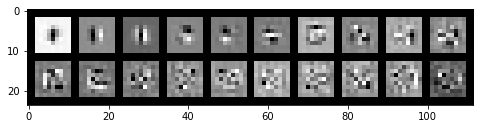

ff
[0.20751042 0.32648815 0.41407136 0.47575537 0.51969639 0.55992374
 0.59678722 0.63073069 0.66351262 0.6917228  0.71709363 0.73809766
 0.75777075 0.77500146 0.79166476 0.80676545 0.82043592 0.83216328
 0.84345596 0.85400001]


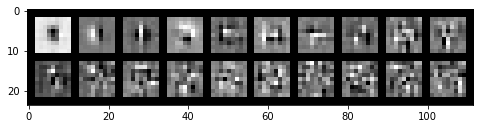

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6199744284261657
lateral
[0.2181097  0.4188966  0.57590592 0.71460475 0.81284084 0.89182813
 0.932814   0.97078045 1.        ]


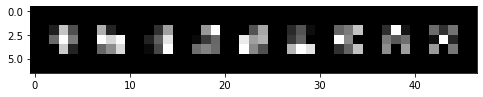

ff
[0.42355383 0.64092448 0.79328459 0.88597172 0.93578851 0.9664961
 0.98379255 0.99640658 1.        ]


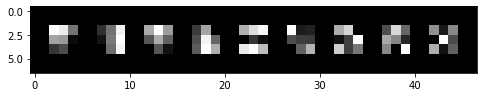

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx38/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.18458678 0.34420128 0.4727782  0.57420038 0.66379291 0.71585461
 0.74956193 0.78218447 0.80905199 0.83261386 0.85402948 0.87035431
 0.88489783 0.89771483 0.90792925 0.9173347  0.92626361 0.93368762
 0.93987817 0.9457893 ]


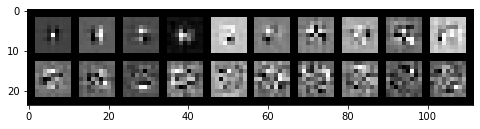

ff
[0.15193326 0.26087019 0.33310726 0.39419358 0.44499236 0.48987866
 0.5271283  0.56188367 0.59325902 0.62173738 0.64871733 0.67368065
 0.69693719 0.71838633 0.73574776 0.75284961 0.76828081 0.78270792
 0.79660504 0.81006059]


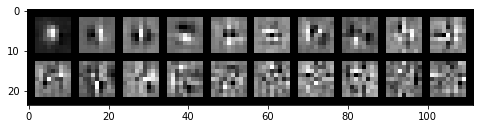

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6199744284261657
lateral
[0.2181097  0.4188966  0.57590592 0.71460475 0.81284084 0.89182813
 0.932814   0.97078045 1.        ]


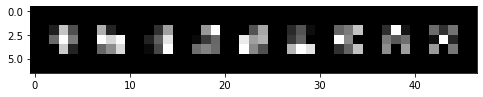

ff
[0.42355383 0.64092448 0.79328459 0.88597172 0.93578851 0.9664961
 0.98379255 0.99640658 1.        ]


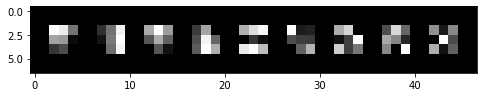

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx39/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.26355708 0.45649759 0.59154497 0.70113919 0.79010587 0.85920038
 0.88663954 0.90832705 0.92797669 0.94006933 0.94914029 0.95544168
 0.96104701 0.96648517 0.9709242  0.97473118 0.97780365 0.98042286
 0.98268272 0.98467101]


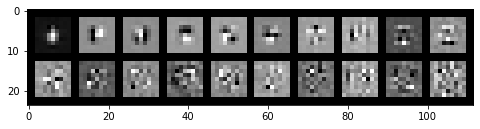

ff
[0.21359778 0.31087261 0.39781543 0.45813688 0.51390347 0.55676033
 0.59478424 0.62997158 0.66223458 0.68996963 0.71451021 0.73494151
 0.75315898 0.77066635 0.78668375 0.80216252 0.81599348 0.82930516
 0.84027567 0.85076966]


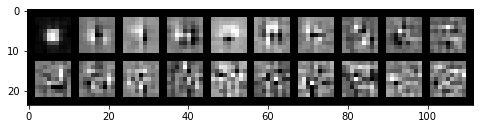

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6221157100588468
lateral
[0.27231272 0.45458491 0.61669828 0.74722197 0.84040101 0.92494395
 0.96581581 0.98710616 1.        ]


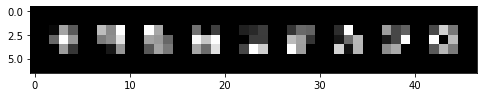

ff
[0.40717193 0.5764538  0.71192594 0.82123532 0.88799    0.94548753
 0.97088839 0.98920074 1.        ]


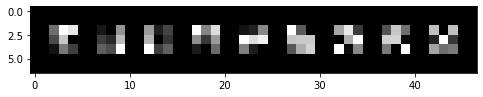

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx102/actrelu/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.23504296 0.38132519 0.48804017 0.57688161 0.63164065 0.67586486
 0.70919944 0.73556827 0.75943166 0.78046163 0.80096718 0.81548234
 0.82883792 0.84027364 0.85107463 0.86174122 0.87047563 0.87859379
 0.88639328 0.89362298]


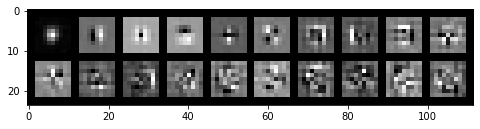

ff
[0.21203534 0.33372075 0.42348618 0.4816741  0.53195534 0.57140808
 0.60470304 0.63462874 0.65963119 0.68272559 0.70432341 0.72450523
 0.74290437 0.75772563 0.77095145 0.78359956 0.79461517 0.80536234
 0.81567469 0.82544678]


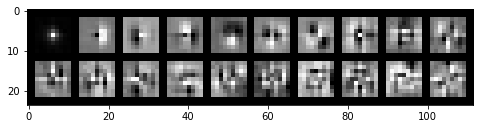

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6603722007976168
lateral
[0.26162265 0.45017828 0.63175832 0.75463706 0.8493113  0.93752908
 0.96466704 0.9842369  1.        ]


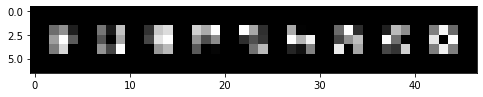

ff
[0.41421263 0.65084553 0.74944222 0.83982937 0.90318074 0.95472702
 0.97316721 0.9878388  1.        ]


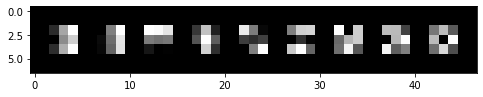

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx102/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.35086139 0.53694001 0.65656611 0.74678674 0.79949717 0.83487038
 0.85958574 0.87771062 0.89299976 0.90388357 0.91294295 0.91973536
 0.92584163 0.93110654 0.93555547 0.93987904 0.94380123 0.94749075
 0.95093822 0.954288  ]


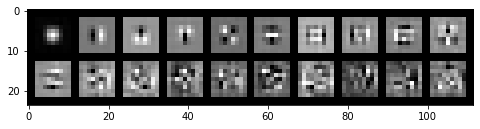

ff
[0.22445414 0.34430988 0.4259393  0.48530777 0.5303032  0.57089553
 0.60902366 0.6395935  0.663426   0.68434287 0.70388023 0.72198651
 0.73694861 0.75150049 0.76543982 0.77891716 0.79128039 0.80215175
 0.81268958 0.82289543]


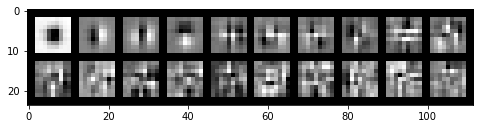

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6603722007976168
lateral
[0.26162265 0.45017828 0.63175832 0.75463706 0.8493113  0.93752908
 0.96466704 0.9842369  1.        ]


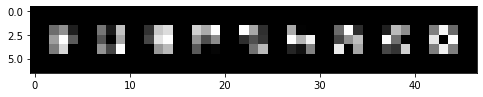

ff
[0.41421263 0.65084553 0.74944222 0.83982937 0.90318074 0.95472702
 0.97316721 0.9878388  1.        ]


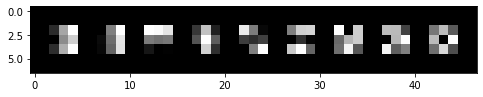

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx103/actrelu/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.20139963 0.34556442 0.42974123 0.49960782 0.54442199 0.58848449
 0.62800607 0.6535285  0.67614048 0.69408916 0.71107199 0.72621668
 0.74023204 0.75260165 0.76428426 0.77543615 0.78573003 0.79505921
 0.80417107 0.81295137]


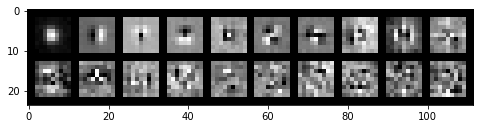

ff
[0.22562298 0.32667746 0.40114279 0.45669542 0.50684102 0.5414747
 0.56869946 0.593752   0.61731933 0.63770355 0.65665693 0.67392121
 0.69024764 0.7048066  0.71868433 0.7303073  0.74093954 0.7509649
 0.76073047 0.77016504]


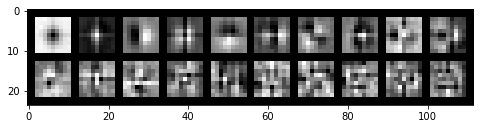

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6523471258179373
lateral
[0.2392097  0.46151167 0.61769745 0.74361897 0.84038093 0.92386815
 0.95698429 0.98361211 1.        ]


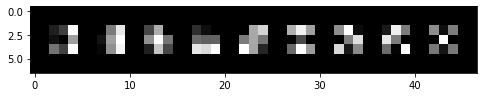

ff
[0.39796285 0.60145397 0.72387348 0.83361952 0.89956353 0.95589275
 0.97480156 0.9901872  1.        ]


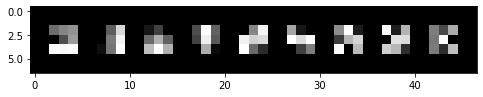

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx103/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.31586778 0.52580019 0.63883959 0.72136465 0.78047945 0.82140679
 0.84533278 0.86452705 0.88017761 0.89190289 0.90310512 0.91192449
 0.91998853 0.92585106 0.93116078 0.93597499 0.94072863 0.94500387
 0.94883548 0.95242328]


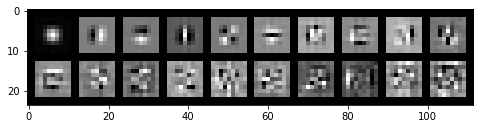

ff
[0.25152508 0.3522303  0.42553325 0.49122574 0.5333421  0.57379489
 0.60809662 0.63970499 0.66893915 0.69207202 0.71200023 0.73086442
 0.74729638 0.7612643  0.77472066 0.78745349 0.79889944 0.80975673
 0.81938979 0.82895067]


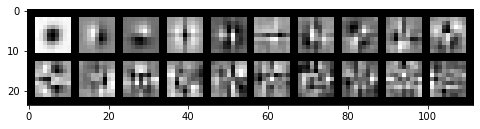

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6523471258179373
lateral
[0.2392097  0.46151167 0.61769745 0.74361897 0.84038093 0.92386815
 0.95698429 0.98361211 1.        ]


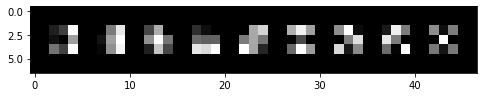

ff
[0.39796285 0.60145397 0.72387348 0.83361952 0.89956353 0.95589275
 0.97480156 0.9901872  1.        ]


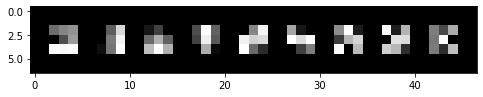

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx166/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.25088969 0.37381424 0.46475247 0.5404721  0.58023296 0.61576102
 0.64641923 0.67586036 0.70028496 0.72014243 0.73571166 0.75029894
 0.7635634  0.77587807 0.78775842 0.79867077 0.80847143 0.8180213
 0.82686981 0.83508842]


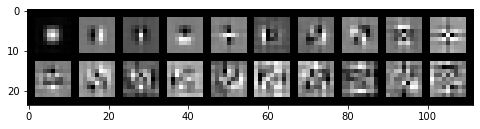

ff
[0.23758718 0.33836017 0.42223631 0.47461194 0.51583597 0.54780377
 0.57839332 0.60745246 0.63031195 0.65065436 0.6684186  0.68572766
 0.70151878 0.71653196 0.73114295 0.74424596 0.75702424 0.76807822
 0.77761376 0.7870143 ]


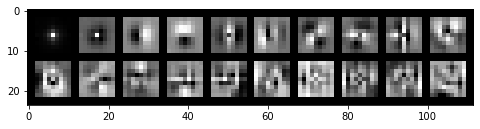

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6736460960042622
lateral
[0.34235849 0.54086945 0.68305703 0.81138023 0.87309434 0.93239088
 0.95840411 0.98062543 1.        ]


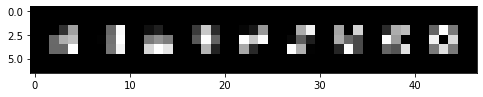

ff
[0.41290241 0.63053051 0.75868014 0.84463727 0.89581328 0.94291562
 0.96545125 0.98306534 1.        ]


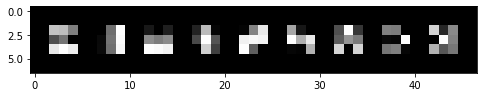

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx167/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.38852679 0.55256446 0.65628502 0.72604968 0.77020218 0.80202906
 0.82594943 0.84720661 0.8641829  0.87501681 0.8849619  0.89351636
 0.90065765 0.90737007 0.91304046 0.9180095  0.92266998 0.92680168
 0.93076851 0.93435063]


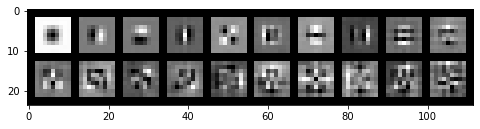

ff
[0.19207853 0.30194978 0.37580271 0.43936729 0.48300672 0.52029019
 0.5525214  0.58228008 0.60706217 0.63045277 0.65076721 0.66970313
 0.68822902 0.70439778 0.71951458 0.73369504 0.74632196 0.75859414
 0.76975374 0.78083747]


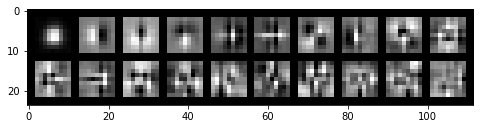

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6750737402088446
lateral
[0.34251664 0.52504579 0.66473192 0.79529771 0.87432048 0.93457955
 0.95953124 0.98165511 1.        ]


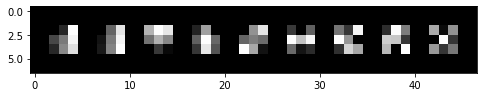

ff
[0.39558952 0.60124142 0.73544128 0.82904253 0.89246262 0.94260988
 0.96516394 0.98561662 1.        ]


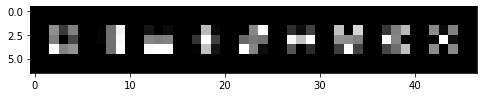

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx167/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.28870966 0.42303194 0.51125338 0.58742238 0.63210096 0.66977937
 0.70351106 0.72933446 0.75379763 0.77139699 0.78723286 0.8011546
 0.81319277 0.82417203 0.83372367 0.84226492 0.85020202 0.85765724
 0.86485135 0.87115683]


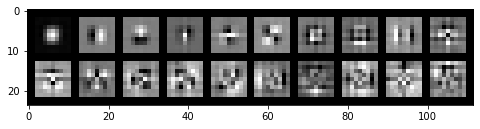

ff
[0.23896262 0.33100775 0.41121444 0.46437883 0.50663899 0.54118989
 0.57154245 0.60085202 0.62803445 0.64867736 0.66828247 0.68626679
 0.70340405 0.71916242 0.73454655 0.74671239 0.75753829 0.76810357
 0.77825042 0.78792887]


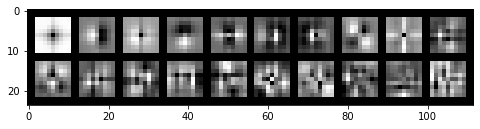

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6750737402088446
lateral
[0.34251664 0.52504579 0.66473192 0.79529771 0.87432048 0.93457955
 0.95953124 0.98165511 1.        ]


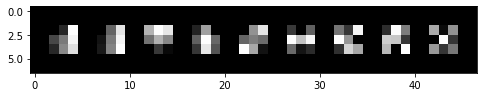

ff
[0.39558952 0.60124142 0.73544128 0.82904253 0.89246262 0.94260988
 0.96516394 0.98561662 1.        ]


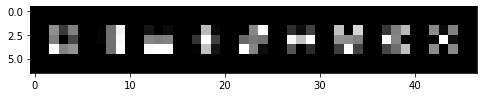

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx230/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.25320769 0.44450978 0.60966815 0.70186188 0.76731811 0.82697236
 0.8570342  0.87887902 0.89649709 0.9109456  0.92195493 0.93172398
 0.94021269 0.94750099 0.95434315 0.95966889 0.96435112 0.96871444
 0.97215562 0.97503958]


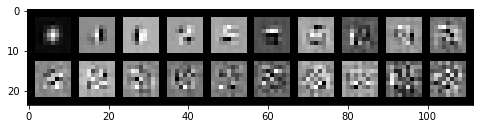

ff
[0.21888376 0.32354901 0.40413582 0.46835438 0.53066355 0.58271606
 0.6256723  0.65553817 0.68317851 0.70767152 0.72916798 0.7490741
 0.76738124 0.78332126 0.79803343 0.81155266 0.82417989 0.83617957
 0.84675081 0.85674361]


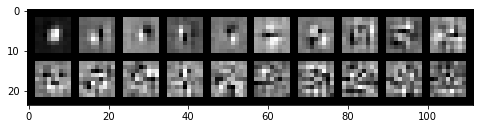

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6202113663302079
lateral
[0.28844672 0.470011   0.62010623 0.75310027 0.87550955 0.92236089
 0.95758468 0.98364015 1.        ]


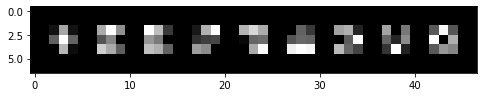

ff
[0.40225701 0.56651459 0.70554477 0.83346083 0.9130745  0.95959789
 0.97688056 0.99032718 1.        ]


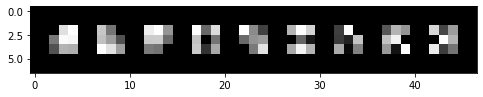

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx231/actrelu/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.23402431 0.38112681 0.49774033 0.56962867 0.62511579 0.66981256
 0.70789243 0.7431115  0.77549297 0.80028938 0.8226665  0.84162034
 0.85702189 0.87071171 0.88307029 0.8945707  0.90526434 0.91423901
 0.92280749 0.93048027]


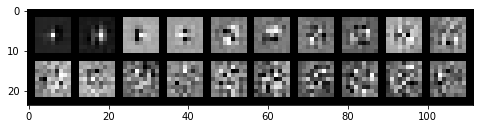

ff
[0.17006562 0.26945947 0.3492542  0.41083214 0.46629727 0.51335982
 0.55091794 0.58590372 0.6182671  0.64476141 0.67046916 0.69408705
 0.71510281 0.73413321 0.75250372 0.76821777 0.78349323 0.79741048
 0.81041275 0.8222897 ]


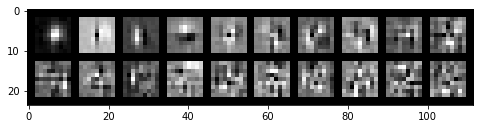

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.613888058953329
lateral
[0.29512563 0.49684959 0.66573098 0.78513668 0.86734268 0.93938986
 0.96259875 0.98356116 1.        ]


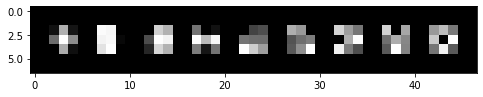

ff
[0.50667186 0.66621113 0.78460792 0.88588965 0.93107609 0.96225116
 0.97802985 0.99040971 1.        ]


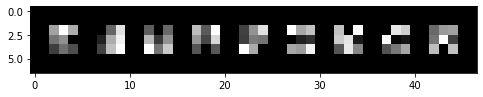

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx231/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.30924272 0.50437923 0.61836829 0.68878143 0.75653247 0.79964437
 0.83377034 0.86322744 0.88115966 0.89752277 0.91079717 0.92136116
 0.93073651 0.93904404 0.94639194 0.9521884  0.95746757 0.96236855
 0.96619155 0.96957352]


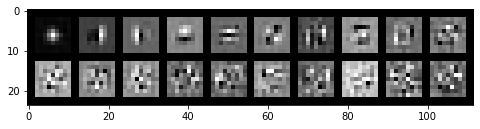

ff
[0.24332845 0.34736082 0.43352595 0.49955696 0.54811934 0.5859066
 0.62020025 0.65168797 0.68033052 0.7060587  0.72889183 0.74973918
 0.76938228 0.78682779 0.80372656 0.81803664 0.8310912  0.84268429
 0.85335081 0.86329294]


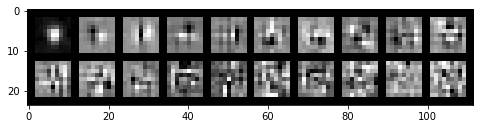

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.613888058953329
lateral
[0.29512563 0.49684959 0.66573098 0.78513668 0.86734268 0.93938986
 0.96259875 0.98356116 1.        ]


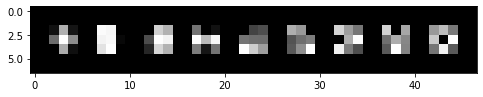

ff
[0.50667186 0.66621113 0.78460792 0.88588965 0.93107609 0.96225116
 0.97802985 0.99040971 1.        ]


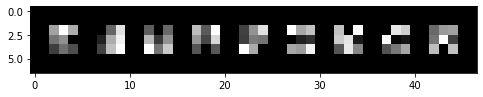

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx294/actrelu/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.18390325 0.29812458 0.39479929 0.46135808 0.50922919 0.54346195
 0.57182737 0.59849723 0.62114862 0.64128645 0.65923827 0.67466898
 0.68927315 0.70361023 0.71716434 0.72902645 0.74076684 0.75165186
 0.76216235 0.77253781]


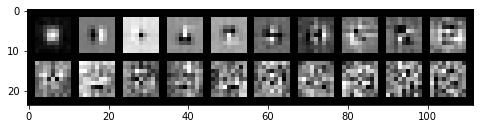

ff
[0.24969205 0.35212374 0.43468443 0.48420565 0.52517042 0.56019598
 0.58518082 0.60575559 0.62573867 0.6445969  0.66217686 0.67747681
 0.691773   0.70514962 0.71752243 0.72910526 0.74028947 0.75004588
 0.75913635 0.76811548]


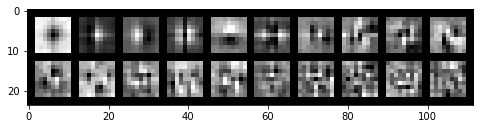

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6550169753428134
lateral
[0.31400755 0.52665771 0.68571746 0.80013877 0.87586954 0.94153735
 0.96886033 0.98683887 1.        ]


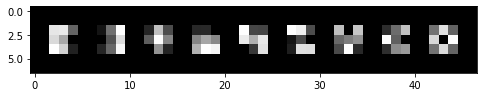

ff
[0.4026875  0.62703879 0.73781544 0.83876733 0.90767274 0.95232296
 0.97236944 0.98894505 1.        ]


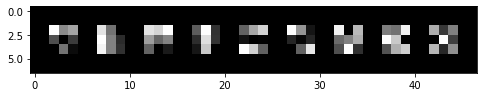

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx294/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.37182662 0.5573983  0.65444846 0.73290202 0.77169543 0.80454062
 0.82877115 0.84848152 0.86454115 0.87704256 0.88867043 0.89751342
 0.90480485 0.91183692 0.91803701 0.92393625 0.92892188 0.93370817
 0.93785199 0.94173051]


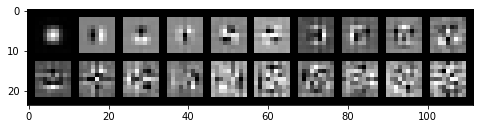

ff
[0.23410636 0.34548264 0.4185402  0.47923975 0.52826681 0.56925498
 0.60633358 0.63438912 0.65920894 0.68276693 0.70471152 0.72379457
 0.74104557 0.75726302 0.77187512 0.78589291 0.79776445 0.80897149
 0.81958264 0.82915483]


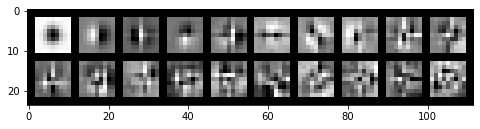

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6550169753428134
lateral
[0.31400755 0.52665771 0.68571746 0.80013877 0.87586954 0.94153735
 0.96886033 0.98683887 1.        ]


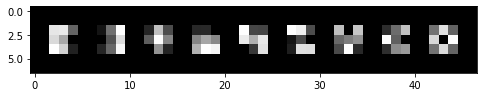

ff
[0.4026875  0.62703879 0.73781544 0.83876733 0.90767274 0.95232296
 0.97236944 0.98894505 1.        ]


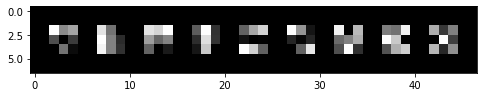

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx295/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.17831377 0.32887635 0.44586152 0.52356821 0.58228799 0.63417302
 0.67307998 0.70164055 0.72692249 0.74888446 0.76895866 0.78679997
 0.80321076 0.81640887 0.8287578  0.83937908 0.84983419 0.85999482
 0.86865631 0.87707266]


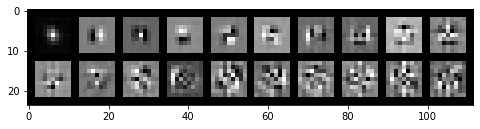

ff
[0.21173544 0.29642247 0.37133386 0.43030131 0.47794786 0.51837878
 0.55419674 0.58820727 0.6129217  0.63471761 0.65531296 0.67436206
 0.69231603 0.7093193  0.72502227 0.73904394 0.75247866 0.76442302
 0.77623365 0.78719895]


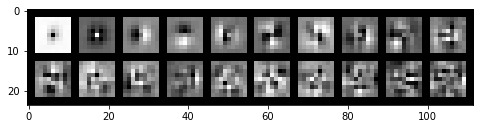

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6520136521993494
lateral
[0.26316808 0.46605782 0.63802585 0.756059   0.85508801 0.9382403
 0.96307409 0.98577071 1.        ]


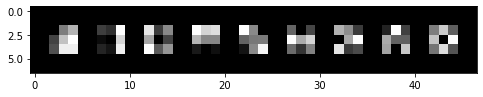

ff
[0.40036323 0.60994989 0.74809035 0.83456086 0.89576471 0.95272048
 0.97172605 0.98681778 1.        ]


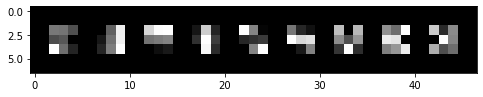

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx358/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.43286583 0.57565909 0.65113003 0.7144638  0.74194426 0.76803991
 0.79127843 0.81309554 0.82934255 0.84256117 0.85248777 0.86084502
 0.86821753 0.87517901 0.88198212 0.88804296 0.89386088 0.89922195
 0.90423503 0.90895567]


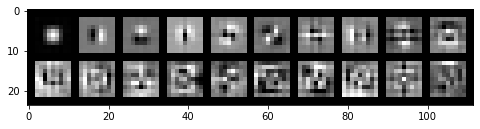

ff
[0.23964635 0.34628025 0.41847225 0.4726551  0.51059747 0.54817864
 0.57903161 0.6073063  0.63175535 0.65239313 0.67111529 0.68817956
 0.7037083  0.71802297 0.73115491 0.7429721  0.75435573 0.76565696
 0.77578293 0.78524413]


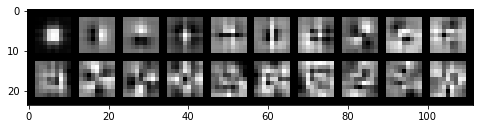

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6531110151470141
lateral
[0.42073296 0.5979005  0.70944279 0.80829159 0.86356553 0.91382523
 0.94495005 0.97353411 1.        ]


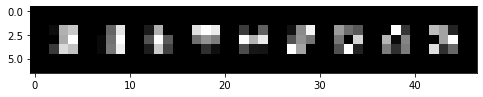

ff
[0.39764171 0.61381656 0.74245459 0.82107585 0.87533197 0.92168124
 0.95144348 0.97767321 1.        ]


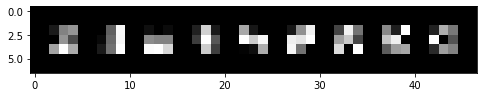

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx358/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.248315   0.34980655 0.43735037 0.48649171 0.52714641 0.56288239
 0.59211817 0.61791843 0.63967658 0.65964969 0.67595769 0.69062993
 0.70319584 0.71514855 0.72659847 0.73656439 0.74605197 0.75517375
 0.76390635 0.77228063]


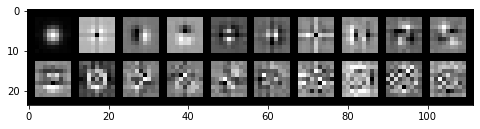

ff
[0.33863522 0.42763973 0.4807513  0.52569097 0.56222346 0.59015777
 0.61776031 0.63746982 0.65593757 0.67246796 0.68853041 0.70346705
 0.71697332 0.72944695 0.74075128 0.75187155 0.76144572 0.77061721
 0.7791183  0.78693246]


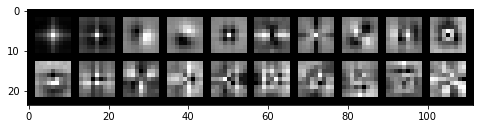

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6531110151470141
lateral
[0.42073296 0.5979005  0.70944279 0.80829159 0.86356553 0.91382523
 0.94495005 0.97353411 1.        ]


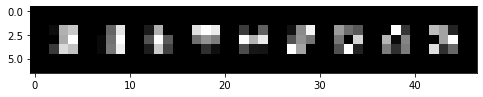

ff
[0.39764171 0.61381656 0.74245459 0.82107585 0.87533197 0.92168124
 0.95144348 0.97767321 1.        ]


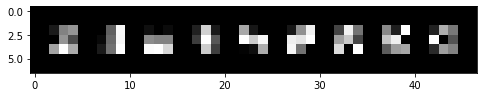

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx359/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.42727004 0.56618392 0.64427235 0.70813216 0.7388762  0.76807722
 0.7895265  0.80859052 0.82521502 0.84030816 0.85355613 0.86249782
 0.87089484 0.87914916 0.88665193 0.8934168  0.89978032 0.90536508
 0.91070705 0.9155037 ]


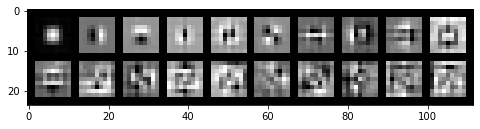

ff
[0.23118007 0.33553759 0.40730983 0.47562263 0.51730742 0.54924835
 0.58041372 0.61078846 0.63536274 0.65683593 0.6775188  0.69709412
 0.71308686 0.72898865 0.7436287  0.75613819 0.76788994 0.7791889
 0.7901167  0.80036471]


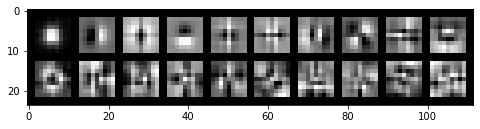

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6744943468986788
lateral
[0.41813029 0.5912939  0.72093442 0.82105805 0.87624134 0.92874773
 0.95540262 0.97838483 1.        ]


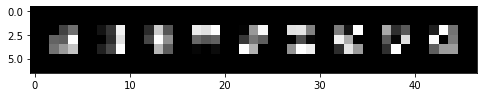

ff
[0.40593363 0.60980985 0.7463964  0.83303101 0.88525723 0.93390397
 0.96041233 0.98178625 1.        ]


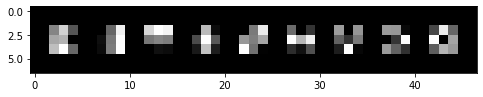

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx422/actrelu/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.18586717 0.35907073 0.48586259 0.58032734 0.64572286 0.69053777
 0.73373604 0.77210961 0.80464176 0.83222355 0.85724    0.87402048
 0.88857166 0.90084298 0.9124791  0.92290895 0.93155706 0.93874496
 0.94561852 0.9517905 ]


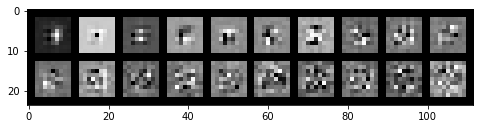

ff
[0.16781619 0.27955448 0.35703282 0.42040965 0.47868961 0.52724191
 0.56955691 0.60372318 0.63473736 0.66287209 0.6887416  0.70925339
 0.72892067 0.7480706  0.76625618 0.78137009 0.79499852 0.80811879
 0.82115304 0.83322315]


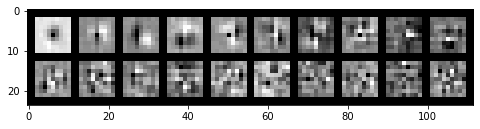

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6171231446799375
lateral
[0.22678999 0.43264736 0.59834925 0.71478337 0.81573969 0.90321496
 0.94705079 0.98407529 1.        ]


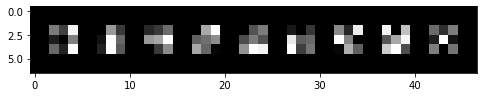

ff
[0.4535034  0.67149126 0.78140279 0.86910328 0.92554056 0.96873106
 0.98399666 0.9928525  1.        ]


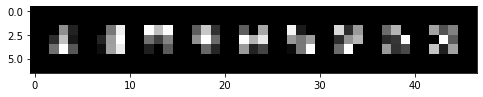

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx422/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.27500885 0.44642632 0.55962811 0.65940334 0.72715957 0.78115906
 0.82301854 0.84855626 0.87252214 0.89212124 0.90954591 0.92365257
 0.93584871 0.94615341 0.95311086 0.95905933 0.96435904 0.96899226
 0.97321352 0.97662866]


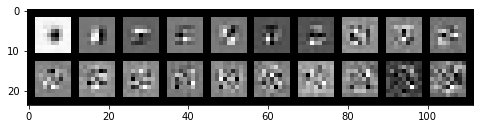

ff
[0.18791126 0.28240046 0.3730817  0.45411008 0.50394582 0.54844392
 0.59126097 0.62703207 0.66080642 0.6894582  0.71416968 0.73656909
 0.75648352 0.77422933 0.79057045 0.80618928 0.82090526 0.83393009
 0.84515697 0.85577702]


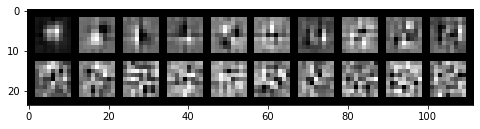

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6171231446799375
lateral
[0.22678999 0.43264736 0.59834925 0.71478337 0.81573969 0.90321496
 0.94705079 0.98407529 1.        ]


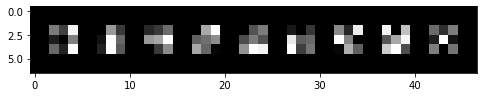

ff
[0.4535034  0.67149126 0.78140279 0.86910328 0.92554056 0.96873106
 0.98399666 0.9928525  1.        ]


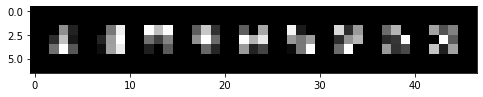

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx423/actrelu/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.2440842  0.37565322 0.49009374 0.56732868 0.6322469  0.68477303
 0.72336843 0.7573494  0.78658436 0.81444359 0.83929908 0.85838134
 0.87394537 0.88747758 0.89870774 0.90943801 0.91798668 0.92621031
 0.93320949 0.94013015]


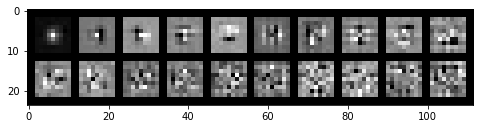

ff
[0.20246462 0.30611738 0.37477164 0.44021164 0.49589982 0.5468687
 0.58783865 0.6231722  0.65156308 0.67893954 0.70150073 0.72344592
 0.7439341  0.76205636 0.77897589 0.79489992 0.80918971 0.82282542
 0.83489357 0.84575474]


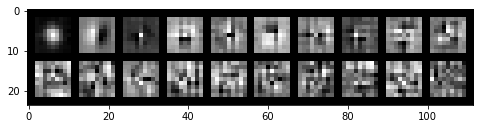

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.5829883740230418
lateral
[0.33721873 0.52890803 0.66869545 0.77867213 0.86764949 0.93757133
 0.96522887 0.98994514 1.        ]


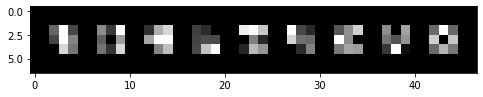

ff
[0.55272197 0.68986049 0.80735325 0.88625723 0.93911922 0.96402606
 0.98021925 0.99235637 1.        ]


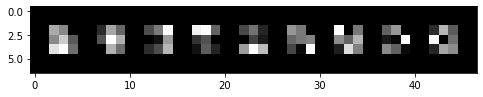

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx423/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.34592161 0.51492057 0.60539327 0.68759769 0.75914782 0.80245691
 0.83519877 0.86467543 0.88470969 0.90129432 0.91394294 0.92441229
 0.93410137 0.94326817 0.95073216 0.95633262 0.961595   0.96602713
 0.96962868 0.97298419]


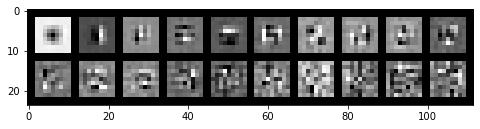

ff
[0.22792394 0.35219602 0.43119338 0.49929678 0.56325471 0.60826081
 0.643958   0.67509916 0.7007966  0.72501185 0.7476527  0.76775088
 0.78578554 0.80220371 0.81733405 0.83041809 0.84339169 0.85553789
 0.86672619 0.87641999]


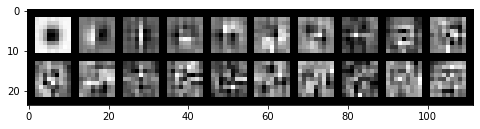

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.5829883740230418
lateral
[0.33721873 0.52890803 0.66869545 0.77867213 0.86764949 0.93757133
 0.96522887 0.98994514 1.        ]


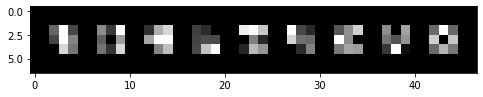

ff
[0.55272197 0.68986049 0.80735325 0.88625723 0.93911922 0.96402606
 0.98021925 0.99235637 1.        ]


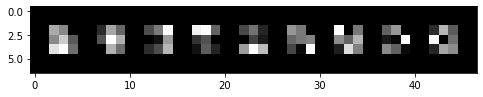

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx486/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.21886107 0.36428562 0.46340733 0.53167317 0.59517398 0.65342711
 0.69654628 0.73148656 0.7594165  0.78251506 0.80207255 0.81901354
 0.83228543 0.84482435 0.85637266 0.8673185  0.87730814 0.88692125
 0.89532474 0.90211178]


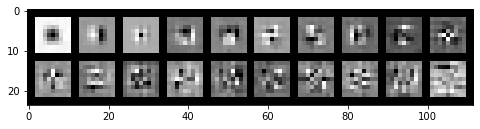

ff
[0.21873139 0.3185163  0.39340959 0.45113186 0.49721561 0.53536605
 0.56841106 0.60106128 0.62830825 0.6514992  0.67230731 0.68972407
 0.7064251  0.72274519 0.73793144 0.75218729 0.76525392 0.77679734
 0.78807755 0.79853665]


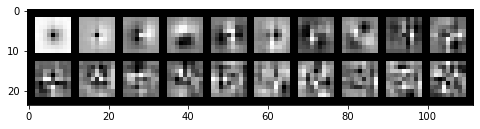

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.643946919324279
lateral
[0.34176805 0.53054622 0.67985176 0.77691911 0.86466165 0.9325978
 0.95979    0.98472261 1.        ]


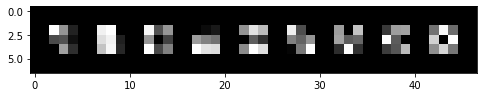

ff
[0.50737139 0.6802125  0.79495935 0.88304724 0.93198714 0.96498494
 0.98041806 0.99178206 1.        ]


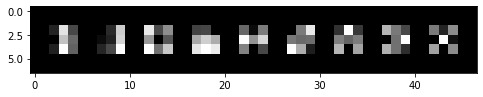

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx487/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.32034071 0.4704807  0.55192258 0.62578878 0.68516365 0.73210219
 0.77583312 0.80524031 0.82984784 0.84869978 0.86570884 0.87823386
 0.8885097  0.89824157 0.90648348 0.91426031 0.92060215 0.92628682
 0.93145946 0.93634927]


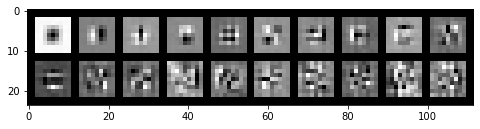

ff
[0.18977433 0.3034263  0.37334909 0.4325078  0.47759946 0.51711121
 0.55387865 0.58638949 0.61388247 0.640244   0.66262259 0.68236217
 0.69990483 0.716464   0.73252492 0.74739996 0.76113089 0.77454201
 0.7864109  0.7978757 ]


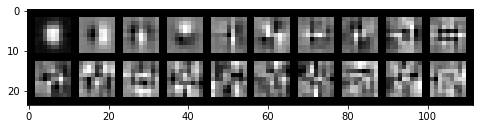

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6470075997292409
lateral
[0.32376155 0.50114593 0.66404533 0.76765608 0.86224256 0.9426035
 0.96643908 0.98507143 1.        ]


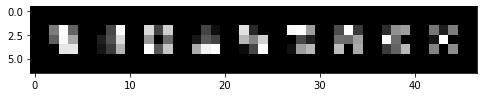

ff
[0.46479795 0.65215885 0.77378652 0.87694265 0.92541978 0.9659091
 0.98095278 0.99117323 1.        ]


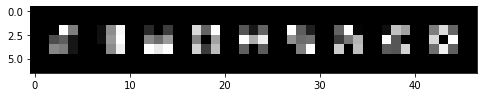

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx487/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.24393512 0.37163005 0.46668231 0.5353611  0.59419697 0.643595
 0.68727314 0.71981374 0.74689469 0.7710434  0.79081891 0.80840609
 0.8220959  0.83450177 0.84489864 0.85461416 0.86339183 0.87149689
 0.87941197 0.88673896]


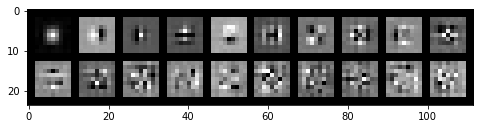

ff
[0.19692783 0.3036122  0.39561237 0.45098856 0.50475845 0.53902309
 0.57197101 0.60277676 0.62519801 0.64655572 0.66590035 0.68433148
 0.70268686 0.71831041 0.73348991 0.7472391  0.76014062 0.77222214
 0.78372727 0.79459389]


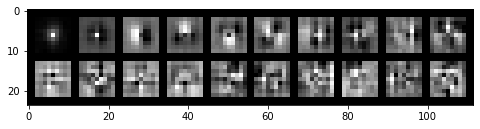

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6470075997292409
lateral
[0.32376155 0.50114593 0.66404533 0.76765608 0.86224256 0.9426035
 0.96643908 0.98507143 1.        ]


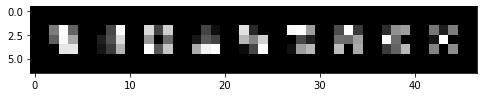

ff
[0.46479795 0.65215885 0.77378652 0.87694265 0.92541978 0.9659091
 0.98095278 0.99117323 1.        ]


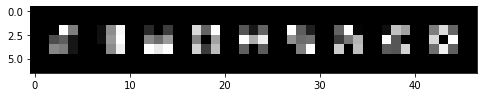

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx550/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.31403267 0.45203558 0.52716657 0.58866789 0.63765267 0.67758057
 0.71101198 0.73908831 0.76462236 0.78459446 0.80252221 0.81636164
 0.82996679 0.84064106 0.85063614 0.85892077 0.86701424 0.87446279
 0.88169746 0.88836226]


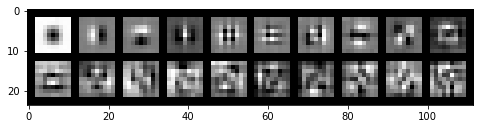

ff
[0.18473646 0.28767185 0.37269638 0.42962541 0.47487211 0.51715477
 0.55099667 0.5836719  0.61094581 0.63632221 0.65831304 0.67811034
 0.69691672 0.71461374 0.73074868 0.74465045 0.75789608 0.77057274
 0.78227623 0.79328824]


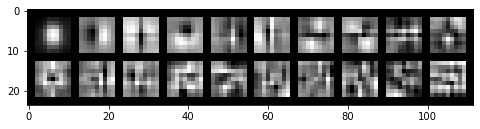

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6588477669205479
lateral
[0.38729432 0.57641002 0.7089301  0.81917754 0.89109119 0.95298437
 0.97108109 0.9868539  1.        ]


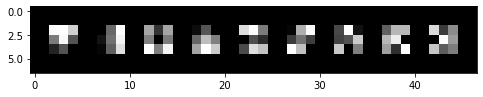

ff
[0.43108533 0.63698555 0.76602259 0.87482358 0.92158593 0.95981701
 0.97574029 0.98823792 1.        ]


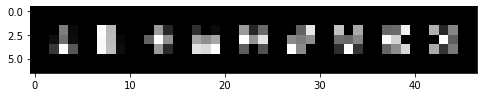

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx551/actrelu/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.31406661 0.41226626 0.48247393 0.54292789 0.59118133 0.62403865
 0.65543247 0.68403747 0.70929261 0.72599585 0.74118173 0.75551022
 0.76876938 0.78011524 0.791355   0.80132711 0.81099591 0.81958603
 0.82760052 0.83542427]


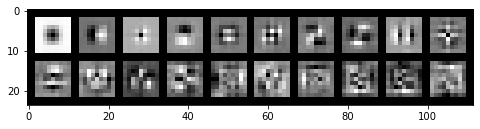

ff
[0.22757889 0.31978858 0.39731397 0.45207407 0.49136092 0.52290234
 0.55143882 0.57797076 0.59847608 0.61816375 0.63683655 0.65414711
 0.67071038 0.68666506 0.70021285 0.71283789 0.72439828 0.7353693
 0.74570161 0.7550711 ]


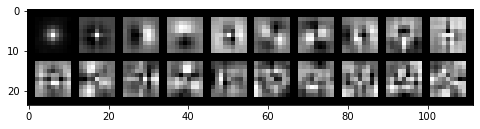

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6603923727200528
lateral
[0.4316147  0.58790694 0.71448592 0.81611771 0.88577792 0.94092194
 0.96237851 0.98221299 1.        ]


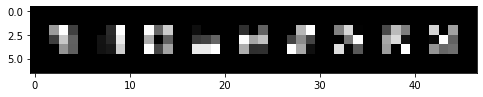

ff
[0.43285569 0.62797496 0.76014061 0.85889624 0.91056943 0.95077299
 0.96873146 0.98649374 1.        ]


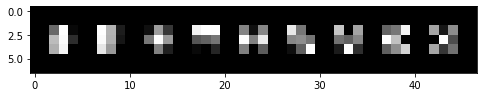

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx551/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.42363762 0.53855173 0.61115502 0.66313464 0.71217715 0.74387542
 0.77326207 0.79810442 0.81928423 0.83225649 0.84474385 0.85467772
 0.86367317 0.87082686 0.8778006  0.88425289 0.89050733 0.89615821
 0.90174081 0.90658298]


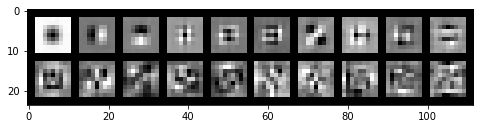

ff
[0.21665423 0.32240705 0.38489028 0.44174128 0.48593621 0.51909689
 0.54939869 0.57764317 0.60060429 0.62129234 0.64073274 0.65972341
 0.67719235 0.69271216 0.70789377 0.72072337 0.73341175 0.74510788
 0.75606611 0.76672458]


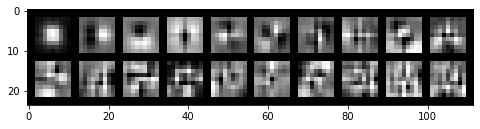

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se0, corr_norm^2 0.6603923727200528
lateral
[0.4316147  0.58790694 0.71448592 0.81611771 0.88577792 0.94092194
 0.96237851 0.98221299 1.        ]


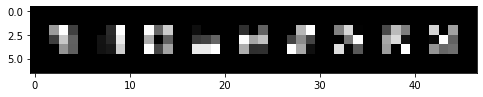

ff
[0.43285569 0.62797496 0.76014061 0.85889624 0.91056943 0.95077299
 0.96873146 0.98649374 1.        ]


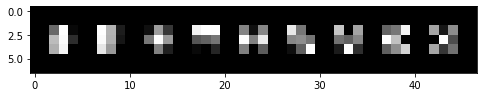

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx614/actrelu/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.23775187 0.40485386 0.49111778 0.57331769 0.63291872 0.6749138
 0.71153247 0.74553201 0.77641336 0.80347403 0.82760639 0.84901718
 0.86724224 0.87968404 0.89145108 0.90235207 0.91254753 0.92121701
 0.92919943 0.93644658]


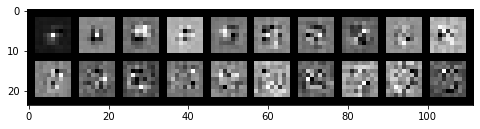

ff
[0.20158792 0.29514884 0.37501897 0.43842242 0.48554569 0.5248409
 0.5621975  0.59619911 0.62646189 0.65364937 0.67895584 0.70071962
 0.72164662 0.74071168 0.75918097 0.77687487 0.79295897 0.80832028
 0.82081234 0.83203072]


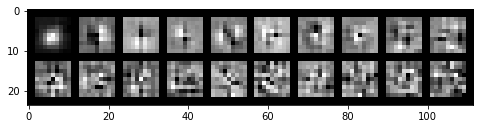

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6193433435604665
lateral
[0.26660731 0.46526361 0.60981551 0.74174718 0.83113281 0.91330684
 0.95394259 0.98395998 1.        ]


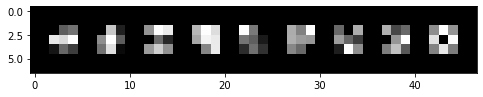

ff
[0.52834281 0.71829227 0.82450548 0.87909716 0.92533497 0.96057176
 0.97650264 0.98978334 1.        ]


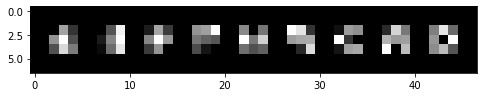

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx614/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.31986017 0.445387   0.54079079 0.62587413 0.69745725 0.73999266
 0.77495308 0.80713203 0.8318605  0.85460275 0.8745941  0.89189127
 0.90545085 0.91700802 0.92648585 0.93531206 0.94309202 0.94995811
 0.95564608 0.96087195]


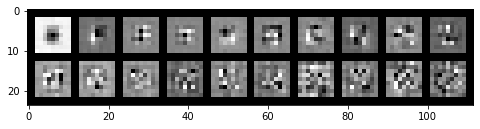

ff
[0.23623822 0.34328466 0.41471794 0.48184337 0.53502952 0.58321194
 0.62306811 0.65583821 0.68671696 0.71099037 0.73409669 0.75521596
 0.77425719 0.79078875 0.80527534 0.81956735 0.8330581  0.84554512
 0.8571738  0.8676884 ]


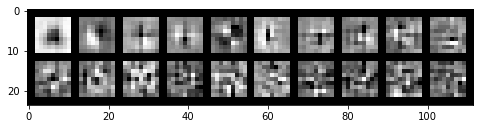

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6193433435604665
lateral
[0.26660731 0.46526361 0.60981551 0.74174718 0.83113281 0.91330684
 0.95394259 0.98395998 1.        ]


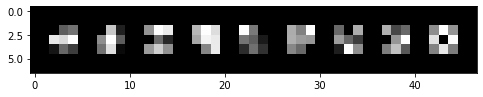

ff
[0.52834281 0.71829227 0.82450548 0.87909716 0.92533497 0.96057176
 0.97650264 0.98978334 1.        ]


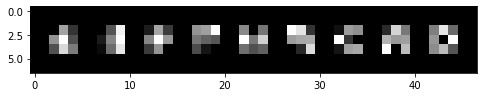

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx615/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.21839596 0.3566319  0.47893727 0.56516505 0.61747741 0.66694575
 0.70711908 0.74151228 0.77096132 0.79766667 0.82301014 0.84441165
 0.86308737 0.88012545 0.89664702 0.91133786 0.92187092 0.93123904
 0.93905774 0.94567643]


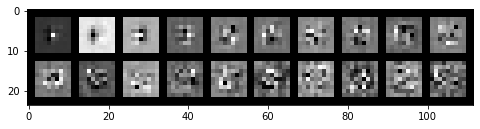

ff
[0.18951462 0.28765568 0.36992446 0.43623797 0.49088692 0.53947987
 0.57731794 0.60975235 0.63842911 0.66391848 0.68708288 0.70932485
 0.73056014 0.74773471 0.76373387 0.77857943 0.79233474 0.80490543
 0.81740618 0.82914075]


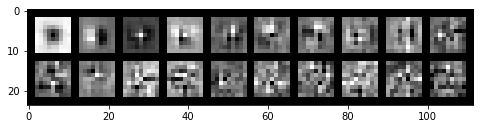

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6243678454825125
lateral
[0.26278647 0.43688689 0.5950979  0.71262023 0.81997046 0.89029484
 0.94084937 0.98110553 1.        ]


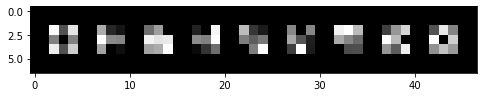

ff
[0.50952543 0.64908587 0.77836473 0.86880716 0.91454081 0.95551394
 0.97891564 0.99162542 1.        ]


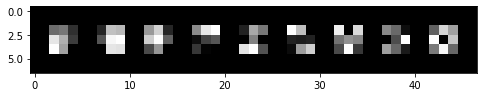

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx678/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.3616497  0.47841951 0.57086245 0.64190801 0.70988768 0.75682585
 0.79539403 0.8245593  0.85101342 0.86913992 0.88416942 0.89580057
 0.90580605 0.91389845 0.92187505 0.9283435  0.93365362 0.93870026
 0.94297016 0.94695225]


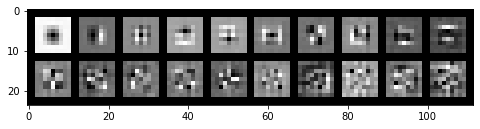

ff
[0.22710808 0.31021506 0.3884191  0.45582664 0.50170476 0.54132404
 0.57738971 0.60525402 0.63155227 0.65457433 0.67482915 0.69464091
 0.71240478 0.72964505 0.74508619 0.76009483 0.77404924 0.78749049
 0.7994355  0.81059803]


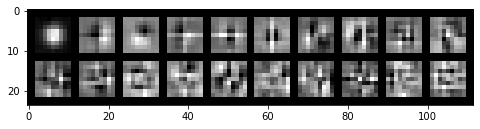

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.656582200770509
lateral
[0.32940353 0.50432879 0.66167042 0.76354613 0.85131848 0.92932515
 0.95970917 0.98384156 1.        ]


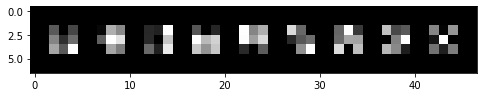

ff
[0.45950475 0.64112302 0.77041931 0.87259874 0.92525973 0.96562579
 0.97995178 0.99291736 1.        ]


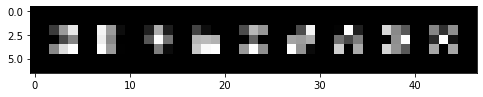

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx678/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.26174738 0.3803996  0.47408096 0.54348621 0.60596156 0.65951211
 0.69736071 0.73031872 0.75889404 0.78074708 0.80096941 0.81729248
 0.82951327 0.84096971 0.85238165 0.86236496 0.87181455 0.88013277
 0.88742523 0.89395231]


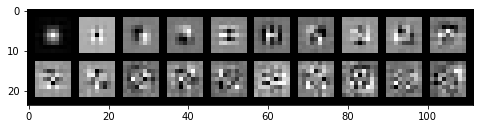

ff
[0.20117674 0.30439746 0.37753188 0.44424143 0.49335059 0.53490073
 0.57102695 0.60071486 0.62770254 0.65048523 0.67229211 0.69237306
 0.7106228  0.72718903 0.74238047 0.75659572 0.76964664 0.78139303
 0.79257862 0.8029642 ]


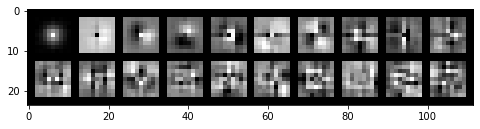

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.656582200770509
lateral
[0.32940353 0.50432879 0.66167042 0.76354613 0.85131848 0.92932515
 0.95970917 0.98384156 1.        ]


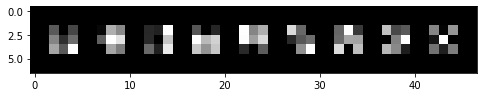

ff
[0.45950475 0.64112302 0.77041931 0.87259874 0.92525973 0.96562579
 0.97995178 0.99291736 1.        ]


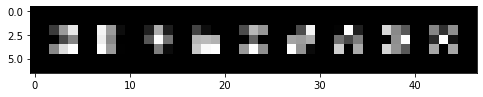

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx679/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.30728499 0.45130382 0.54822619 0.62587388 0.69384233 0.73924146
 0.78107596 0.80961233 0.83708094 0.8604648  0.87468161 0.88710439
 0.89866871 0.90923658 0.91866882 0.92669564 0.93345588 0.93892968
 0.94355627 0.94777168]


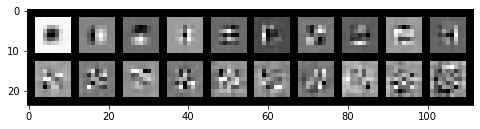

ff
[0.19726605 0.28978224 0.36110881 0.41735306 0.45975591 0.50094426
 0.53794617 0.572013   0.60395009 0.6323906  0.65883859 0.68152213
 0.70268891 0.72124879 0.738449   0.75380856 0.76838935 0.78194625
 0.79486365 0.80734321]


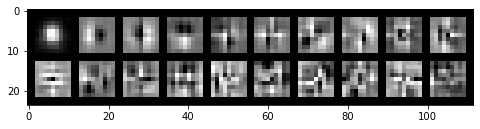

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.659025185289284
lateral
[0.28775751 0.45640854 0.60484323 0.73566245 0.83282116 0.92141474
 0.95776649 0.9853021  1.        ]


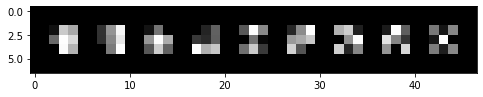

ff
[0.4373177  0.63535782 0.7536028  0.84933088 0.90332109 0.95284321
 0.97416164 0.98877654 1.        ]


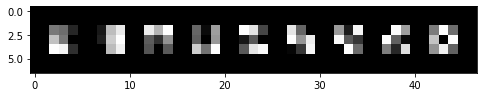

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx742/actrelu/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.24692763 0.3583798  0.43246284 0.50344053 0.55877627 0.60385409
 0.64283331 0.67790814 0.71115742 0.73195237 0.74966413 0.76498236
 0.7788213  0.79190043 0.80284855 0.81357466 0.82290875 0.83185872
 0.8406183  0.84831387]


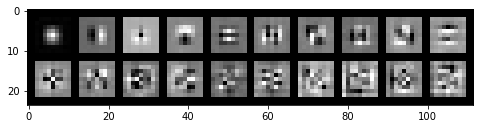

ff
[0.20281284 0.2881754  0.36703435 0.42323591 0.46220709 0.49522903
 0.52588013 0.55353635 0.57830831 0.59949655 0.61971412 0.63859933
 0.65485031 0.67054881 0.68597718 0.69935087 0.71212239 0.72422497
 0.73469981 0.74513295]


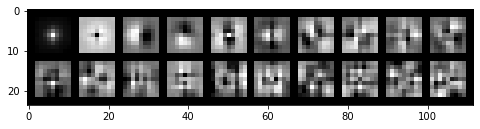

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6817130036989621
lateral
[0.34537958 0.53295972 0.66661143 0.79113177 0.87535763 0.94654229
 0.96857847 0.9867671  1.        ]


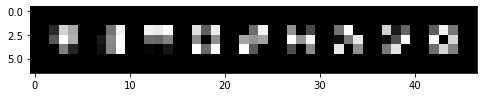

ff
[0.4104296  0.59764447 0.74170988 0.85482858 0.91000535 0.95594761
 0.97484488 0.98968989 1.        ]


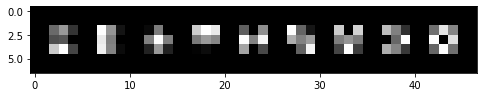

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx742/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.34549613 0.47826038 0.56809979 0.62834758 0.68077566 0.72829092
 0.7655238  0.79827893 0.82603013 0.84630428 0.86066193 0.8715817
 0.88150759 0.88945036 0.89673657 0.9036346  0.90925768 0.91453278
 0.91930496 0.92402279]


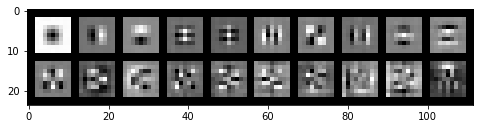

ff
[0.17516648 0.27312406 0.34147061 0.40806865 0.45311342 0.49257695
 0.5270091  0.55443826 0.58053243 0.60465873 0.62573496 0.64551466
 0.66455461 0.68221143 0.6983366  0.71380146 0.72754127 0.74042805
 0.75262491 0.76431722]


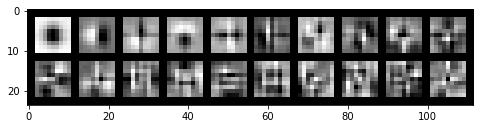

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6817130036989621
lateral
[0.34537958 0.53295972 0.66661143 0.79113177 0.87535763 0.94654229
 0.96857847 0.9867671  1.        ]


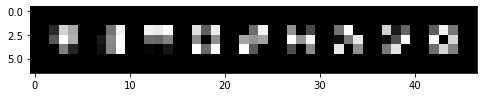

ff
[0.4104296  0.59764447 0.74170988 0.85482858 0.91000535 0.95594761
 0.97484488 0.98968989 1.        ]


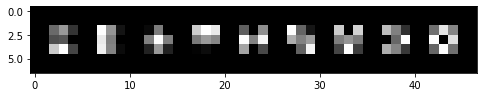

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx743/actrelu/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.26540543 0.38337184 0.46394335 0.53385671 0.58851521 0.62533529
 0.65813248 0.68980512 0.71782701 0.73816954 0.75475646 0.76869299
 0.78206932 0.79341207 0.80303247 0.81244745 0.82095256 0.82904945
 0.83692019 0.84420209]


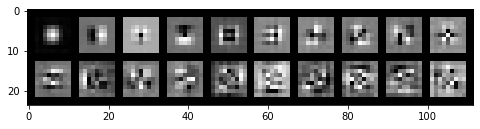

ff
[0.18242553 0.26615731 0.34100504 0.39577727 0.43463999 0.4680044
 0.49964652 0.52975887 0.5570421  0.57855521 0.59929212 0.6176616
 0.63555847 0.65207865 0.66834458 0.68312424 0.69696824 0.70915732
 0.72127221 0.73313607]


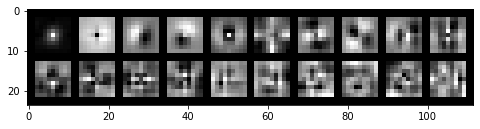

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6719229257718388
lateral
[0.38275972 0.56243246 0.70281597 0.81515552 0.88086539 0.94080868
 0.96487965 0.98451975 1.        ]


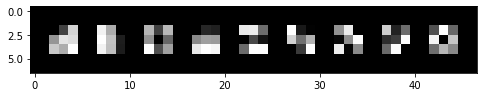

ff
[0.44778177 0.62739962 0.75260224 0.86388407 0.91260996 0.95659723
 0.97469756 0.98959794 1.        ]


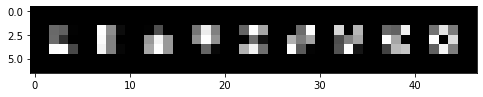

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx743/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.38116872 0.52504874 0.61266201 0.6699971  0.72248388 0.76218546
 0.79279247 0.82011413 0.84073896 0.85542409 0.86683758 0.87664635
 0.88531906 0.89297288 0.89992119 0.90593717 0.91139192 0.91671041
 0.92140616 0.92598666]


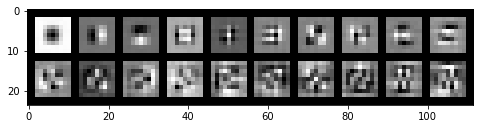

ff
[0.18256485 0.2725754  0.34904601 0.41073658 0.45639689 0.49467586
 0.52900882 0.55890435 0.58743111 0.61059952 0.6324219  0.65346368
 0.67410503 0.69267865 0.70938066 0.72478626 0.73924292 0.75321633
 0.76659258 0.77824602]


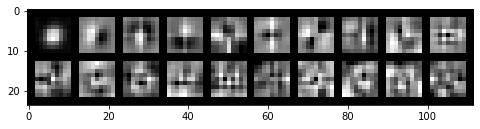

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se0, corr_norm^2 0.6719229257718388
lateral
[0.38275972 0.56243246 0.70281597 0.81515552 0.88086539 0.94080868
 0.96487965 0.98451975 1.        ]


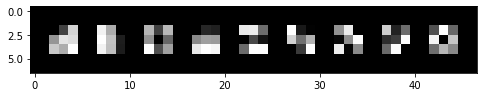

ff
[0.44778177 0.62739962 0.75260224 0.86388407 0.91260996 0.95659723
 0.97469756 0.98959794 1.        ]


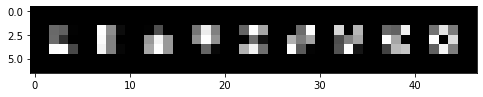

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx806/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.23954299 0.39959663 0.51451214 0.61570798 0.69268995 0.74728779
 0.78742277 0.82010186 0.84489607 0.86689936 0.88035699 0.89164867
 0.90205676 0.91161295 0.92100069 0.92862491 0.93611224 0.9431575
 0.94942215 0.95449819]


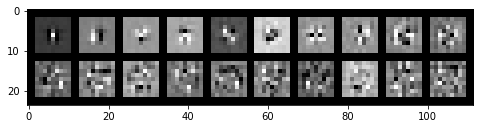

ff
[0.12463872 0.22681576 0.31785888 0.38739598 0.4425398  0.493147
 0.53471405 0.57154459 0.60252272 0.63193798 0.66093848 0.68721695
 0.70945055 0.73127956 0.75090026 0.76750318 0.78384901 0.79872292
 0.81275549 0.82600114]


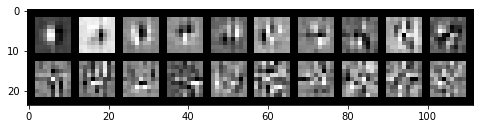

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6223807696337461
lateral
[0.31047799 0.47106866 0.60976008 0.72813069 0.82928906 0.91806882
 0.95925995 0.98235382 1.        ]


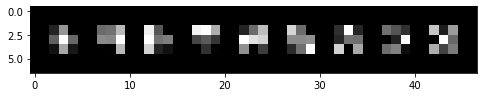

ff
[0.39848088 0.62342663 0.75786369 0.85467206 0.91663555 0.95967171
 0.9818025  0.99094451 1.        ]


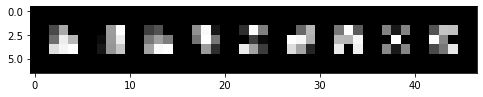

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx807/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.22352147 0.41874981 0.55961055 0.66877366 0.74052068 0.79829004
 0.83346939 0.86751517 0.88742663 0.90371875 0.91803895 0.92860719
 0.93811979 0.94730164 0.95430345 0.95910269 0.96364171 0.96736474
 0.97092658 0.97415168]


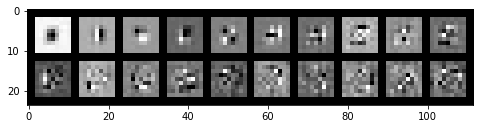

ff
[0.21072268 0.3174718  0.4050532  0.47556747 0.52112746 0.56135107
 0.59782576 0.63311935 0.66262133 0.68932696 0.71169977 0.73207481
 0.75145649 0.76911514 0.78530306 0.80007987 0.81303816 0.8252469
 0.83664986 0.84746493]


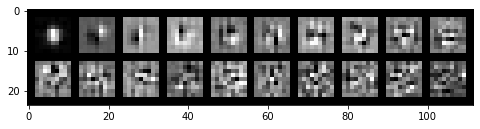

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6245983468398907
lateral
[0.2594601  0.43080888 0.57896994 0.71210138 0.81848859 0.91465882
 0.96148063 0.98189208 1.        ]


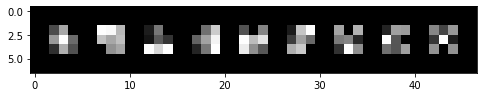

ff
[0.44774537 0.63829797 0.76099633 0.85279153 0.92337236 0.96547781
 0.98144556 0.9933791  1.        ]


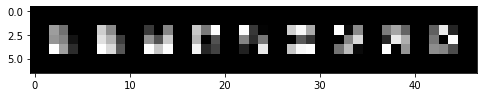

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx807/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.20621939 0.35102822 0.46741904 0.56510522 0.63598201 0.68721949
 0.72901878 0.7636835  0.79309391 0.81886072 0.83968143 0.85766661
 0.87228728 0.88534513 0.89719705 0.90742447 0.91633438 0.92479164
 0.93266537 0.93918403]


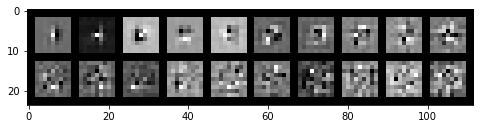

ff
[0.16816832 0.26952521 0.3380893  0.4030617  0.45618787 0.49928702
 0.54115076 0.57522052 0.6047913  0.63176245 0.65675061 0.67980561
 0.70097313 0.72047247 0.73828981 0.75523151 0.77125938 0.78632157
 0.79959189 0.81163753]


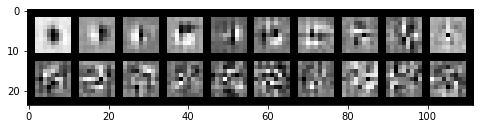

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6245983468398907
lateral
[0.2594601  0.43080888 0.57896994 0.71210138 0.81848859 0.91465882
 0.96148063 0.98189208 1.        ]


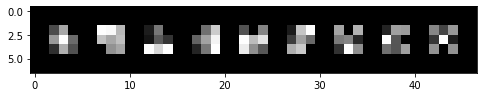

ff
[0.44774537 0.63829797 0.76099633 0.85279153 0.92337236 0.96547781
 0.98144556 0.9933791  1.        ]


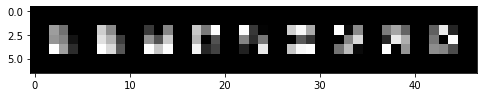

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx870/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.34293635 0.54539553 0.6752385  0.75958517 0.80761278 0.84308692
 0.86843949 0.88536055 0.90082825 0.91412033 0.9255081  0.93209202
 0.938344   0.94339208 0.94800855 0.95227232 0.95615841 0.95965883
 0.96271599 0.9652313 ]


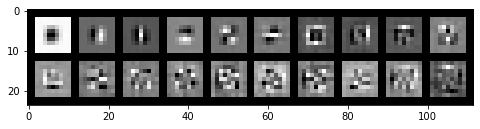

ff
[0.21223699 0.31353883 0.38393661 0.44597551 0.49515005 0.54029845
 0.57843641 0.61062182 0.63852454 0.66141721 0.68336111 0.70282178
 0.72072967 0.7366827  0.7515407  0.76592312 0.77920703 0.79171253
 0.80348318 0.81515464]


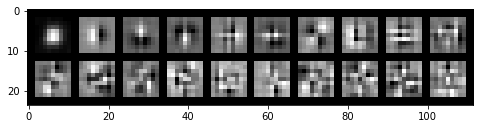

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6520756769325996
lateral
[0.27821278 0.48126187 0.66480355 0.77428073 0.85723976 0.9341018
 0.96078508 0.98369457 1.        ]


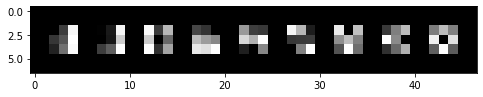

ff
[0.37385147 0.59325196 0.72170156 0.8265773  0.89342144 0.94702375
 0.96948833 0.98684472 1.        ]


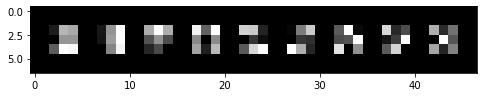

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx871/actrelu/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.24234346 0.40808009 0.52110091 0.59919958 0.6500622  0.68833088
 0.72242353 0.75152117 0.77313742 0.79125996 0.80742627 0.82165419
 0.834016   0.84520912 0.85608639 0.86566612 0.87424083 0.88187502
 0.88938647 0.8967968 ]


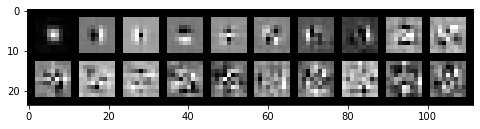

ff
[0.23109503 0.34035617 0.42495621 0.48480415 0.5353857  0.57344827
 0.60828671 0.63888431 0.66512429 0.68970484 0.7099928  0.72822421
 0.74595654 0.76235026 0.77532255 0.78758274 0.79958968 0.81053211
 0.82087048 0.83083283]


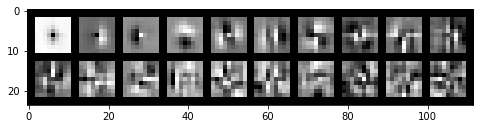

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6482644130362523
lateral
[0.31864011 0.49959416 0.6684249  0.78917185 0.87059037 0.93999934
 0.96305195 0.98374311 1.        ]


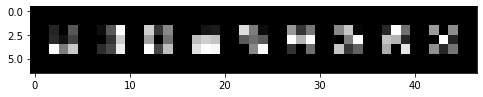

ff
[0.40651027 0.62469037 0.73099534 0.83020926 0.89472729 0.94594917
 0.96851778 0.98832448 1.        ]


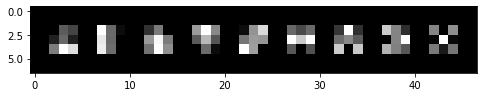

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx871/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.39359356 0.57970194 0.68152592 0.77859702 0.81883727 0.84481924
 0.86698116 0.88511869 0.89902107 0.90977801 0.91884844 0.92594098
 0.9323085  0.9375336  0.94214152 0.94641519 0.95021754 0.9536428
 0.95688222 0.95960837]


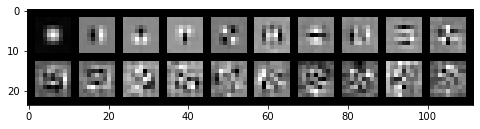

ff
[0.23983741 0.34486047 0.40977355 0.46805649 0.51026973 0.54902197
 0.58357143 0.61457315 0.64077116 0.66453915 0.68657885 0.70656668
 0.72536205 0.74272808 0.75863853 0.77330433 0.78607922 0.79816156
 0.80930996 0.82005919]


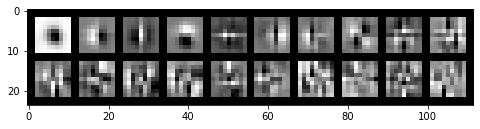

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6482644130362523
lateral
[0.31864011 0.49959416 0.6684249  0.78917185 0.87059037 0.93999934
 0.96305195 0.98374311 1.        ]


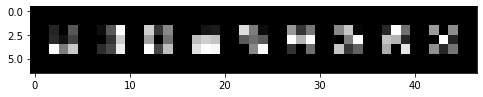

ff
[0.40651027 0.62469037 0.73099534 0.83020926 0.89472729 0.94594917
 0.96851778 0.98832448 1.        ]


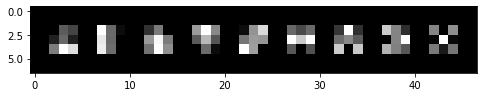

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx934/actrelu/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.19205755 0.2817617  0.36360226 0.40414823 0.43999695 0.47286009
 0.49723968 0.5163239  0.53466682 0.55225486 0.56886468 0.58355739
 0.59655505 0.60886742 0.62081517 0.63194936 0.64252014 0.65286402
 0.66286255 0.67251936]


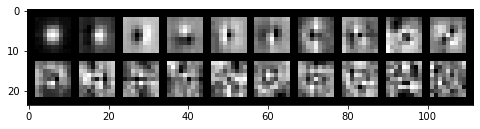

ff
[0.30092471 0.36650822 0.41645713 0.44996082 0.47728731 0.50166443
 0.52141933 0.53738258 0.55319437 0.56834871 0.58173339 0.59466084
 0.60700007 0.61832898 0.62904832 0.63887277 0.6483074  0.65738128
 0.6660874  0.67459648]


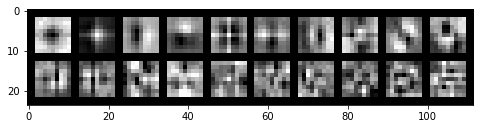

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6721479868699023
lateral
[0.3555398  0.55659511 0.69341002 0.81213067 0.88123899 0.93703195
 0.96018292 0.980968   1.        ]


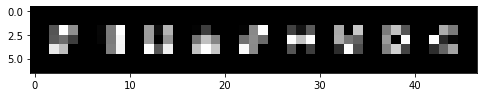

ff
[0.38606296 0.61008547 0.7393922  0.83338182 0.88738995 0.93527593
 0.96442938 0.98347956 1.        ]


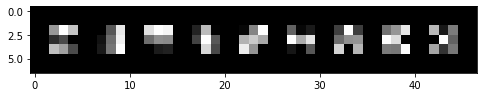

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx934/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.4028956  0.58293274 0.67452964 0.74922102 0.7831166  0.80746508
 0.82794715 0.84588184 0.8611075  0.87130763 0.88056655 0.88931143
 0.89607026 0.90195649 0.90744431 0.91273405 0.91765843 0.92213421
 0.9261581  0.93009965]


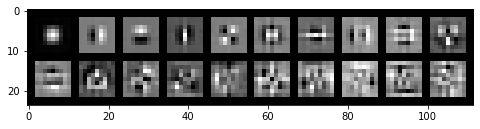

ff
[0.22586262 0.33881304 0.40980321 0.47286208 0.51474745 0.55311474
 0.58769182 0.61738619 0.64091165 0.66362103 0.68403806 0.70382447
 0.72208782 0.7379732  0.75225614 0.76575276 0.77756221 0.78876359
 0.79899264 0.80899644]


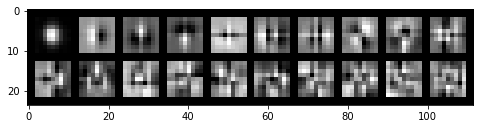

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6721479868699023
lateral
[0.3555398  0.55659511 0.69341002 0.81213067 0.88123899 0.93703195
 0.96018292 0.980968   1.        ]


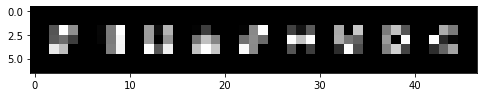

ff
[0.38606296 0.61008547 0.7393922  0.83338182 0.88738995 0.93527593
 0.96442938 0.98347956 1.        ]


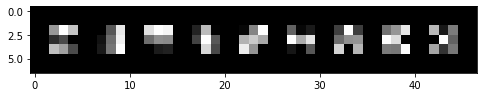

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx935/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.26545574 0.39669171 0.48406227 0.55444958 0.59768227 0.6331116
 0.66410139 0.69225646 0.71616553 0.73756337 0.75381743 0.76908504
 0.78284551 0.79489494 0.80583324 0.81552854 0.82476862 0.83362302
 0.84178999 0.84953069]


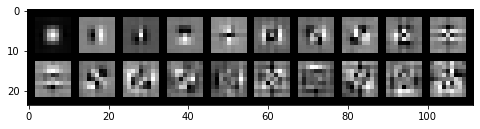

ff
[0.26533417 0.37425032 0.44805826 0.50161812 0.54208105 0.57267231
 0.60168951 0.62827997 0.65040984 0.67000165 0.68788916 0.70450662
 0.72031257 0.73466888 0.74736641 0.75907368 0.77035305 0.78076132
 0.79033683 0.79897435]


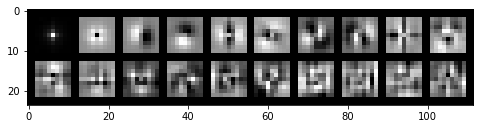

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6714271572978623
lateral
[0.36514296 0.55983562 0.69739989 0.82286881 0.88261506 0.93925731
 0.96099147 0.98227475 1.        ]


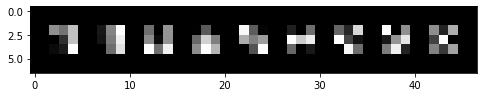

ff
[0.40201801 0.61053588 0.74437901 0.83348672 0.88859029 0.93893276
 0.96472773 0.98306151 1.        ]


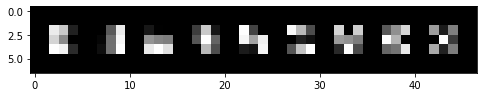

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx998/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.27401546 0.45266112 0.59412494 0.69658986 0.78548625 0.84068677
 0.87376215 0.89193953 0.90854365 0.92067819 0.93082325 0.93909627
 0.94619256 0.95269714 0.95789684 0.96256763 0.9666232  0.97030799
 0.97360435 0.97627348]


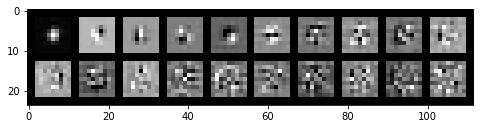

ff
[0.15726037 0.26246361 0.35634572 0.42390627 0.48489984 0.53750307
 0.58024891 0.61459008 0.64759995 0.67516551 0.69915867 0.72151643
 0.74076717 0.75908708 0.77646263 0.79299306 0.80787522 0.82160096
 0.83483851 0.84722564]


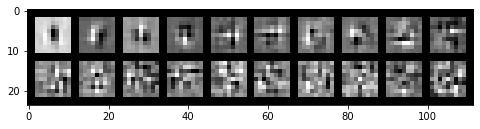

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6142176850084105
lateral
[0.29523279 0.47922695 0.62143969 0.73105808 0.83868302 0.9187083
 0.95505727 0.98489538 1.        ]


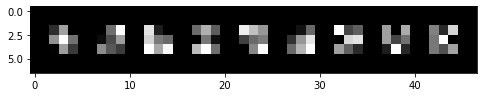

ff
[0.39105748 0.58902601 0.73876544 0.83275843 0.90534833 0.95143921
 0.97568749 0.9898844  1.        ]


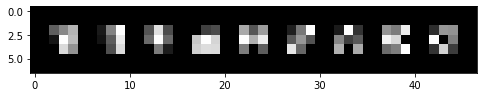

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx998/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.21691334 0.3648995  0.47359784 0.55426137 0.63040493 0.68690157
 0.72493692 0.75916951 0.78652547 0.81221359 0.83512067 0.85119102
 0.86585121 0.8795152  0.89129383 0.90222965 0.91184351 0.92069509
 0.92892067 0.93628939]


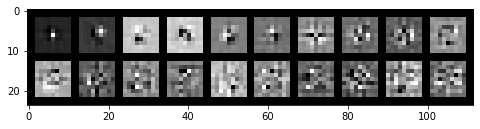

ff
[0.13849264 0.22584244 0.30743869 0.37594416 0.43332739 0.48772776
 0.53123436 0.56694106 0.59744433 0.62559468 0.65145736 0.67361918
 0.69483356 0.71536774 0.73511691 0.75414089 0.77183046 0.78678164
 0.8011187  0.81475271]


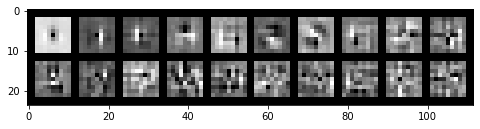

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6142176850084105
lateral
[0.29523279 0.47922695 0.62143969 0.73105808 0.83868302 0.9187083
 0.95505727 0.98489538 1.        ]


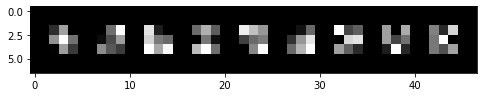

ff
[0.39105748 0.58902601 0.73876544 0.83275843 0.90534833 0.95143921
 0.97568749 0.9898844  1.        ]


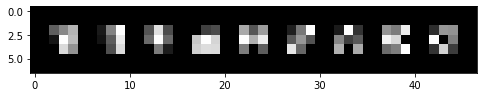

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx999/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.29089998 0.46758892 0.60158875 0.71809747 0.7874312  0.82982567
 0.85867368 0.88560328 0.90302745 0.91690272 0.92751976 0.93625519
 0.94413341 0.9503182  0.95547639 0.96017749 0.96431728 0.9683845
 0.9716323  0.97479102]


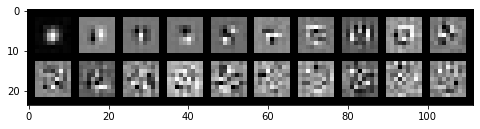

ff
[0.24534516 0.35119367 0.43086968 0.50473128 0.56472989 0.61037334
 0.64487938 0.67755238 0.70744017 0.73274769 0.7564435  0.77748596
 0.79721358 0.81268838 0.82753039 0.84110222 0.85333508 0.86460029
 0.87499193 0.88321165]


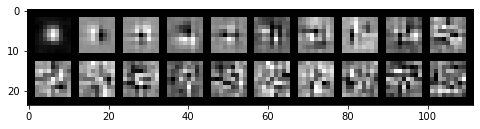

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6166026041489062
lateral
[0.25487896 0.45936804 0.62840173 0.741078   0.84340675 0.92762598
 0.96107183 0.9853853  1.        ]


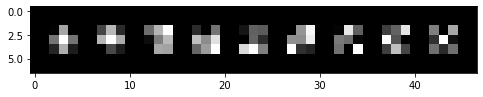

ff
[0.4079421  0.61693634 0.7553161  0.83590695 0.90637454 0.96044216
 0.98073777 0.99453269 1.        ]


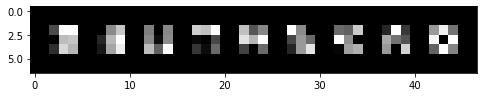

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1062/actrelu/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.25778334 0.40429485 0.50925982 0.57920268 0.62560402 0.66097546
 0.69006739 0.71846653 0.74287006 0.76270321 0.78049504 0.79687804
 0.81084948 0.82235229 0.8325695  0.8421552  0.85152249 0.85992474
 0.86765319 0.87470572]


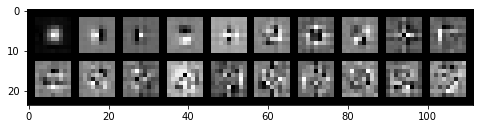

ff
[0.24109364 0.36436757 0.45907854 0.51144611 0.55825078 0.59406292
 0.62518538 0.65420464 0.67881723 0.70148446 0.72084271 0.73847922
 0.7552613  0.77004729 0.78286884 0.79493187 0.80620823 0.81695721
 0.82647081 0.83558762]


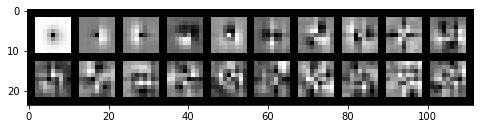

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.650769979902205
lateral
[0.34874049 0.53921162 0.68175759 0.80107269 0.87006737 0.93173962
 0.95801666 0.98041532 1.        ]


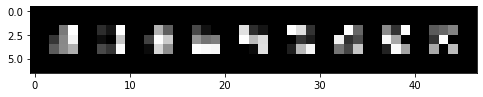

ff
[0.43193572 0.63326519 0.752374   0.8245834  0.89052146 0.94608003
 0.96728962 0.98536265 1.        ]


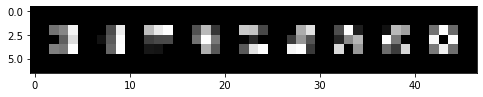

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1062/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.40928287 0.58330699 0.6862904  0.76954548 0.80727911 0.83190232
 0.85117395 0.86583167 0.87880528 0.89121564 0.90100165 0.90969947
 0.9177092  0.92387475 0.92925304 0.93433825 0.93886686 0.94287034
 0.94654614 0.94982599]


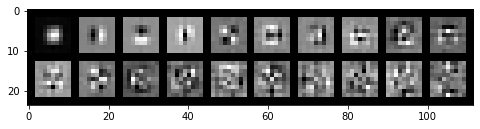

ff
[0.26039321 0.38759213 0.46032243 0.51964641 0.57566909 0.61565426
 0.64938334 0.67698136 0.70399044 0.7254946  0.74328056 0.76002783
 0.77560519 0.78934399 0.8019567  0.81381165 0.82474749 0.83491426
 0.84419771 0.85283091]


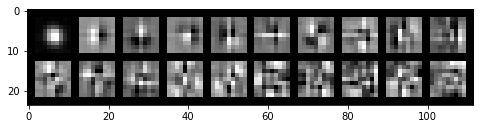

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.650769979902205
lateral
[0.34874049 0.53921162 0.68175759 0.80107269 0.87006737 0.93173962
 0.95801666 0.98041532 1.        ]


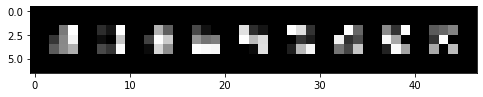

ff
[0.43193572 0.63326519 0.752374   0.8245834  0.89052146 0.94608003
 0.96728962 0.98536265 1.        ]


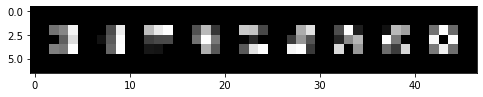

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1063/actrelu/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.17407393 0.27802479 0.35743186 0.40531295 0.45128803 0.48272689
 0.50849006 0.53261408 0.55542733 0.5757965  0.59460898 0.61127485
 0.62706692 0.64154118 0.65548241 0.66890807 0.6815826  0.69354905
 0.70503402 0.71581757]


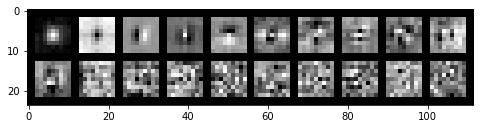

ff
[0.2869273  0.37137805 0.43072435 0.47591469 0.50991819 0.54020434
 0.56554849 0.58782569 0.60675553 0.62327161 0.63885882 0.65402827
 0.66789015 0.68034325 0.69256821 0.70387432 0.71426249 0.72403775
 0.73363671 0.74255091]


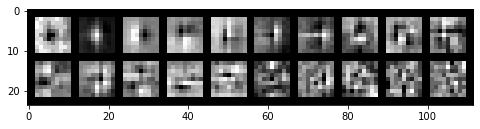

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6528172758966946
lateral
[0.31198199 0.50086769 0.66512303 0.77614257 0.86021455 0.93411829
 0.96133233 0.98269465 1.        ]


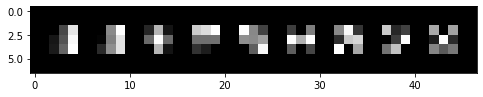

ff
[0.43630105 0.66104803 0.76048626 0.85282007 0.91075056 0.9556348
 0.97434095 0.98809148 1.        ]


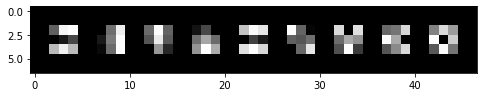

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1063/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.34534993 0.52372663 0.62991387 0.70717159 0.75933332 0.78908547
 0.81432653 0.83845069 0.85966428 0.871128   0.88141316 0.8908087
 0.89963797 0.90759308 0.91466382 0.92079656 0.92592489 0.93063222
 0.9346471  0.93850139]


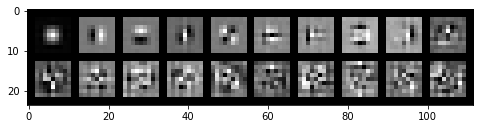

ff
[0.25186702 0.36926149 0.44275331 0.50933128 0.55117399 0.58943875
 0.62555027 0.65397652 0.67944782 0.70245623 0.72299624 0.73937335
 0.75571394 0.77145672 0.78597912 0.79871372 0.81018485 0.82089668
 0.83037913 0.83937536]


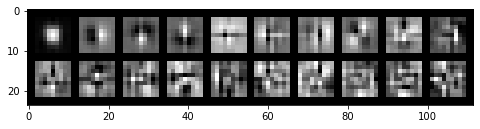

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6528172758966946
lateral
[0.31198199 0.50086769 0.66512303 0.77614257 0.86021455 0.93411829
 0.96133233 0.98269465 1.        ]


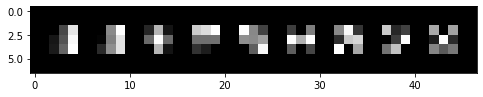

ff
[0.43630105 0.66104803 0.76048626 0.85282007 0.91075056 0.9556348
 0.97434095 0.98809148 1.        ]


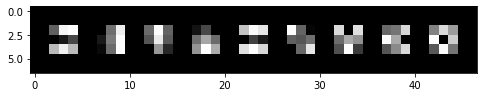

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1126/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.2519485  0.36212894 0.44474231 0.50612218 0.55307055 0.59123419
 0.62525758 0.65738161 0.6837998  0.70797659 0.72677166 0.74398535
 0.75939085 0.77204714 0.78377513 0.79488637 0.80538726 0.81445385
 0.82311452 0.83131453]


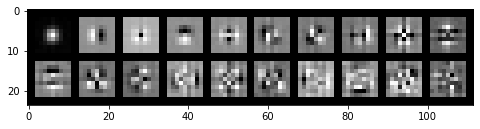

ff
[0.26167814 0.35824826 0.43078332 0.4796682  0.52016904 0.54958183
 0.57733333 0.6041349  0.62632498 0.64508294 0.66331096 0.67980852
 0.69473748 0.70896829 0.72261506 0.734485   0.74612594 0.75612113
 0.76541689 0.7744667 ]


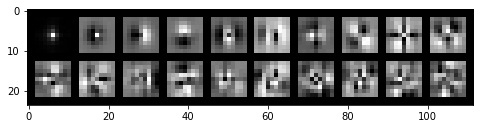

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6773248491585808
lateral
[0.39769969 0.59141765 0.72371773 0.83077963 0.8887002  0.94173164
 0.96398723 0.98304923 1.        ]


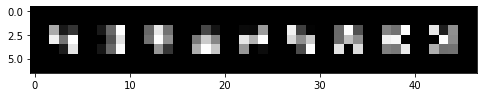

ff
[0.40848225 0.63611636 0.76176774 0.8451595  0.90233373 0.94837919
 0.96822796 0.98612195 1.        ]


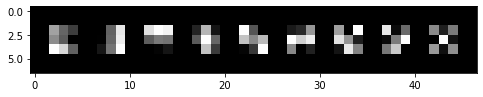

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1127/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.42581283 0.56967177 0.65091585 0.72316084 0.75264609 0.78129433
 0.80627586 0.82467941 0.83792797 0.84830405 0.85823001 0.86711957
 0.87473135 0.88210096 0.88909754 0.89557066 0.90102492 0.90626928
 0.9111721  0.91581434]


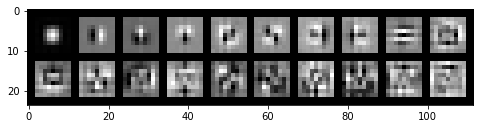

ff
[0.23724677 0.33631249 0.39944999 0.45368803 0.49547674 0.53137161
 0.56247026 0.591543   0.61439742 0.63566929 0.65561703 0.67269597
 0.6890947  0.70442638 0.71805683 0.73104853 0.7425503  0.75386911
 0.76386188 0.77342798]


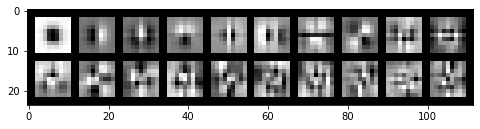

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6677939357363986
lateral
[0.41156133 0.58769093 0.71536774 0.82198401 0.88073795 0.93319129
 0.95678179 0.97902204 1.        ]


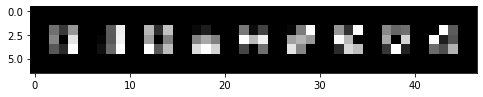

ff
[0.43650065 0.64268943 0.76370812 0.83902858 0.89081563 0.93624588
 0.96002753 0.98010565 1.        ]


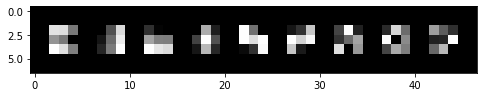

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1127/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.28505552 0.38811508 0.47638826 0.5323727  0.57229952 0.60619243
 0.63143021 0.65525844 0.6768364  0.69555682 0.7116028  0.72636797
 0.73852233 0.74985565 0.76062406 0.77019367 0.77943291 0.78781427
 0.79568874 0.80324119]


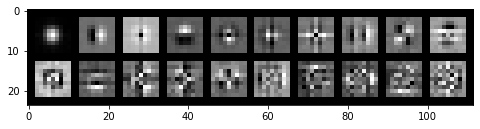

ff
[0.33753731 0.43456809 0.49771397 0.53779757 0.57674326 0.6093132
 0.63463731 0.65783819 0.67744669 0.69558113 0.71265354 0.72769936
 0.7421826  0.75549277 0.76678192 0.77702715 0.78629874 0.79501163
 0.80242411 0.8098058 ]


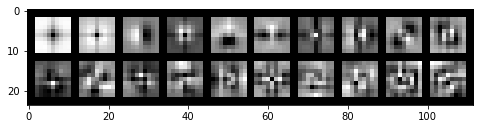

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6677939357363986
lateral
[0.41156133 0.58769093 0.71536774 0.82198401 0.88073795 0.93319129
 0.95678179 0.97902204 1.        ]


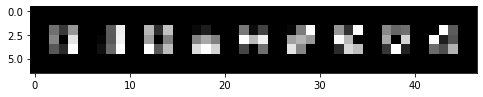

ff
[0.43650065 0.64268943 0.76370812 0.83902858 0.89081563 0.93624588
 0.96002753 0.98010565 1.        ]


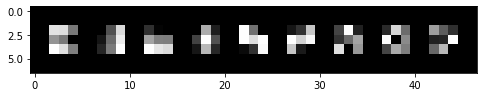

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1190/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.29458614 0.45644556 0.55218776 0.64274453 0.70886427 0.76677301
 0.81167787 0.85377681 0.87592523 0.8947091  0.90838596 0.92138798
 0.93263534 0.94215549 0.9500078  0.95620995 0.96165508 0.96653342
 0.97089632 0.97424475]


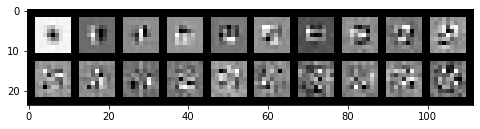

ff
[0.20523393 0.32117299 0.42079978 0.48141412 0.53317983 0.57677088
 0.61743987 0.64658979 0.67334609 0.69819298 0.72089257 0.7429773
 0.76234267 0.78004434 0.79668798 0.8100793  0.82228975 0.83426162
 0.8458456  0.85549589]


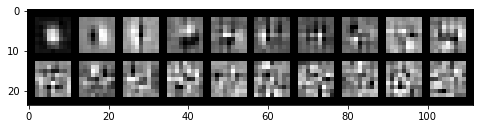

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.5997784961429065
lateral
[0.22637749 0.42734432 0.59647385 0.74240539 0.82920979 0.90883051
 0.95579554 0.98228673 1.        ]


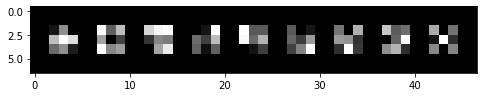

ff
[0.51082037 0.71172456 0.82224705 0.88484432 0.93538875 0.96543629
 0.98631723 0.99542744 1.        ]


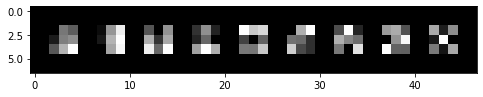

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1191/actrelu/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.17163591 0.31043802 0.43130032 0.52829575 0.61959411 0.68009125
 0.72636277 0.76368711 0.79388077 0.82092161 0.84359102 0.86030609
 0.87564194 0.89052114 0.90468339 0.91622875 0.92554317 0.93390839
 0.9407764  0.94690463]


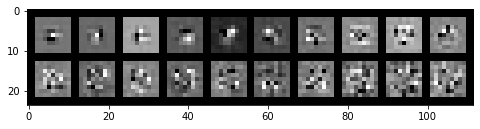

ff
[0.14864042 0.24144074 0.31567042 0.37884371 0.4323721  0.4830255
 0.52134552 0.55900529 0.5911325  0.62166073 0.65092703 0.67712319
 0.69995554 0.72060466 0.73941441 0.75746411 0.77304273 0.78800199
 0.80173928 0.81512829]


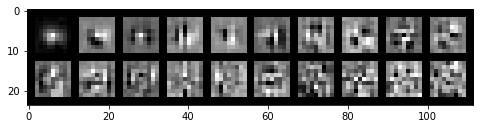

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6094166336129911
lateral
[0.18756236 0.36146509 0.53319503 0.68321957 0.7950863  0.8967106
 0.949679   0.9861488  1.        ]


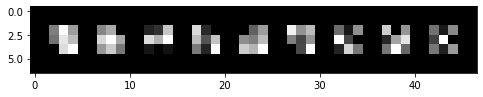

ff
[0.49255121 0.64420204 0.77507341 0.87832791 0.92600861 0.96700031
 0.98342759 0.99435884 1.        ]


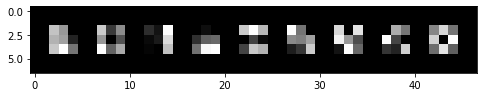

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1191/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.17787278 0.33661141 0.47581272 0.58229481 0.68142525 0.75031863
 0.7933829  0.82714737 0.85385321 0.87789485 0.89578943 0.91257095
 0.92517203 0.93558503 0.94440473 0.95191697 0.95857773 0.96508713
 0.96950785 0.97368359]


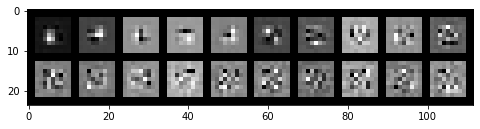

ff
[0.19412377 0.28676948 0.3604472  0.41684977 0.47136362 0.51795555
 0.55518567 0.59234199 0.62610396 0.65615402 0.68155331 0.70559081
 0.72791871 0.74652572 0.76397561 0.78093572 0.7962144  0.81030491
 0.82330425 0.836015  ]


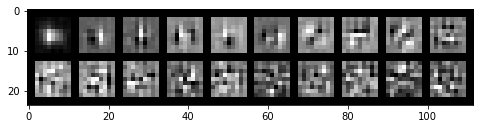

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6094166336129911
lateral
[0.18756236 0.36146509 0.53319503 0.68321957 0.7950863  0.8967106
 0.949679   0.9861488  1.        ]


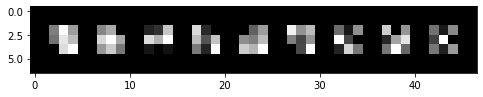

ff
[0.49255121 0.64420204 0.77507341 0.87832791 0.92600861 0.96700031
 0.98342759 0.99435884 1.        ]


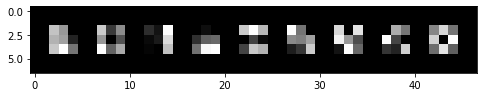

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1254/actrelu/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.29323279 0.40326244 0.49401269 0.55145774 0.60592183 0.6544621
 0.69027347 0.71785961 0.74392576 0.76465134 0.78151888 0.79761531
 0.8118104  0.82345762 0.83424734 0.84466725 0.85421436 0.86307613
 0.87122952 0.87891741]


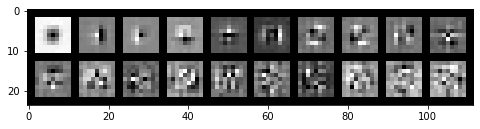

ff
[0.21598671 0.31665109 0.39470303 0.45568846 0.49831929 0.53170819
 0.56448955 0.59533996 0.62257747 0.64712542 0.66810355 0.68726232
 0.70483009 0.7204851  0.73567988 0.74987499 0.7624181  0.77383855
 0.78484359 0.79533483]


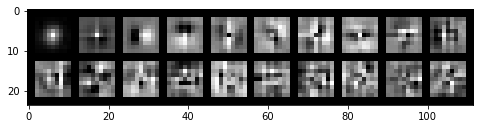

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6446164372350426
lateral
[0.33880292 0.5137913  0.67505052 0.78022268 0.87541722 0.94533514
 0.9679156  0.98726709 1.        ]


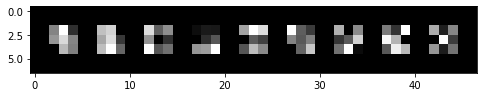

ff
[0.46605399 0.64564797 0.76971224 0.88087996 0.92999566 0.96796723
 0.98095456 0.99201946 1.        ]


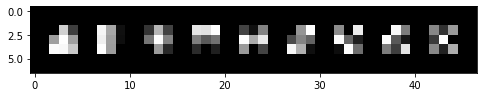

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1254/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.40074504 0.54270517 0.62621085 0.69769138 0.74074387 0.77825138
 0.81270237 0.8372559  0.86063929 0.87627365 0.8884551  0.89818509
 0.90674936 0.91415587 0.92105586 0.9269729  0.93253337 0.9376351
 0.94188766 0.94594115]


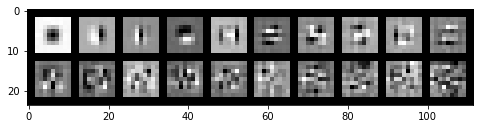

ff
[0.24556001 0.34385718 0.4244013  0.4964663  0.53979866 0.58017749
 0.61815229 0.65035087 0.67680167 0.69752506 0.71708177 0.7352519
 0.75325003 0.77060291 0.78626193 0.79962799 0.81058186 0.8212645
 0.83180256 0.84108846]


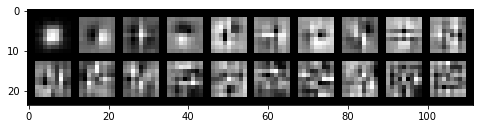

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6446164372350426
lateral
[0.33880292 0.5137913  0.67505052 0.78022268 0.87541722 0.94533514
 0.9679156  0.98726709 1.        ]


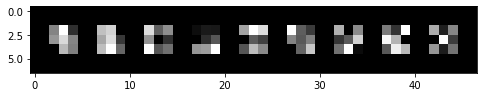

ff
[0.46605399 0.64564797 0.76971224 0.88087996 0.92999566 0.96796723
 0.98095456 0.99201946 1.        ]


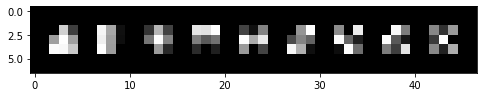

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1255/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.22671029 0.33368055 0.43883358 0.50919581 0.56725089 0.61656631
 0.65686965 0.69089257 0.7232055  0.74831946 0.76727479 0.78574439
 0.80106483 0.81502655 0.82791843 0.83859114 0.84868344 0.85832283
 0.86742597 0.87536451]


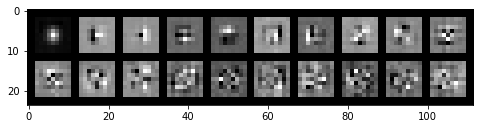

ff
[0.20194415 0.30844626 0.39934322 0.45715809 0.50889327 0.54765927
 0.58413236 0.613969   0.64003721 0.66142229 0.68015889 0.69853713
 0.71554545 0.73177841 0.7457147  0.75873566 0.77130923 0.7826644
 0.7930203  0.80272212]


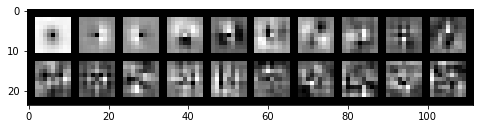

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6466639993324228
lateral
[0.2905034  0.47022887 0.6407037  0.75709986 0.8663845  0.9394348
 0.96365528 0.98374524 1.        ]


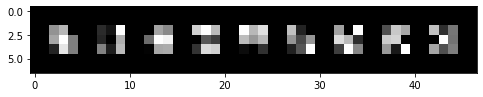

ff
[0.46962363 0.65451443 0.77271601 0.86656441 0.91827191 0.9605615
 0.97989942 0.99100364 1.        ]


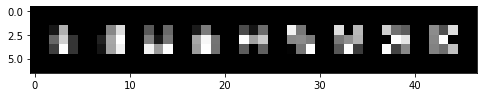

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1318/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.36801326 0.49169098 0.57227969 0.63839892 0.69109162 0.72616999
 0.75684371 0.78243648 0.80635128 0.82230703 0.83521983 0.84657682
 0.85630921 0.86490832 0.87281262 0.88012554 0.88691512 0.89274021
 0.89832893 0.9032058 ]


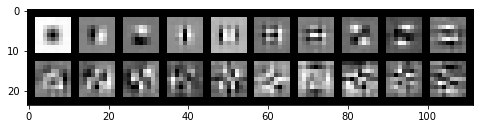

ff
[0.17975902 0.27511317 0.34706827 0.40909319 0.45426525 0.49590064
 0.53010041 0.55903931 0.58399453 0.60814966 0.62987504 0.65036946
 0.6698086  0.68757765 0.70431468 0.71892443 0.73259525 0.74550694
 0.75770992 0.7693218 ]


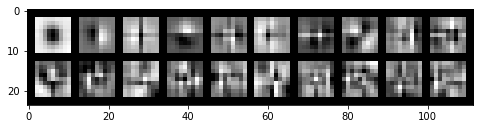

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6624371123885079
lateral
[0.3875108  0.57035257 0.70123958 0.82316454 0.89511822 0.95488343
 0.97187529 0.98700284 1.        ]


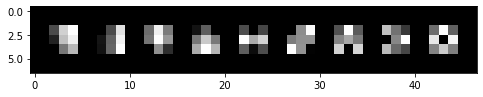

ff
[0.43052704 0.63559568 0.76424274 0.85739248 0.91311597 0.95554208
 0.97241006 0.98795355 1.        ]


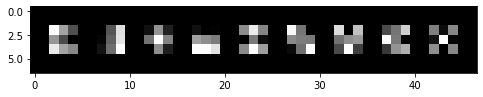

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1318/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.27797055 0.38152397 0.46722141 0.5351944  0.58421774 0.62480634
 0.65761122 0.68487427 0.70731628 0.72724526 0.74458391 0.76024092
 0.77317165 0.78507084 0.79568683 0.80505711 0.81431841 0.82282286
 0.83049235 0.83767366]


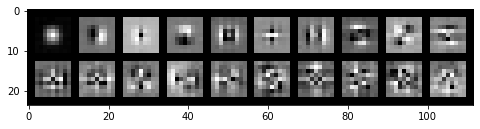

ff
[0.19600659 0.27483824 0.35014746 0.39958998 0.44248189 0.4769872
 0.51004995 0.53840243 0.56415136 0.58627458 0.60620163 0.62441175
 0.64173646 0.65815646 0.67371478 0.68750346 0.70059558 0.71355932
 0.724182   0.73465474]


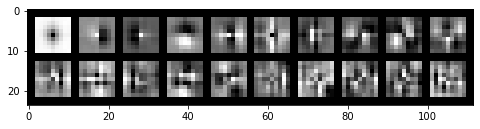

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6624371123885079
lateral
[0.3875108  0.57035257 0.70123958 0.82316454 0.89511822 0.95488343
 0.97187529 0.98700284 1.        ]


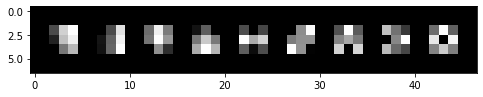

ff
[0.43052704 0.63559568 0.76424274 0.85739248 0.91311597 0.95554208
 0.97241006 0.98795355 1.        ]


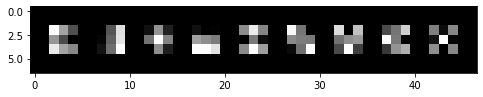

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1319/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.33806631 0.48798311 0.564267   0.62433673 0.66870981 0.70542482
 0.73907378 0.76575221 0.79145586 0.81279179 0.82726632 0.84035132
 0.85167477 0.86065056 0.86913559 0.87719262 0.88399627 0.89060112
 0.89654603 0.90234157]


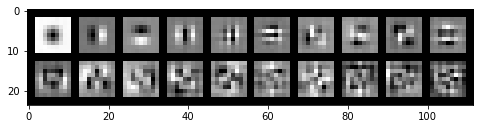

ff
[0.17544568 0.27173085 0.35074147 0.40998748 0.45999247 0.50094905
 0.53292586 0.56393705 0.58947606 0.6135288  0.63625976 0.65800741
 0.67783372 0.69671436 0.71447747 0.73002315 0.74501874 0.75914331
 0.77221362 0.7840932 ]


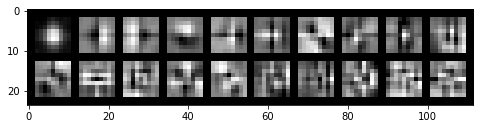

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lmse/m_se1, corr_norm^2 0.6518409597346869
lateral
[0.37416227 0.57507312 0.69902568 0.80555642 0.88721545 0.95068336
 0.97001509 0.98679601 1.        ]


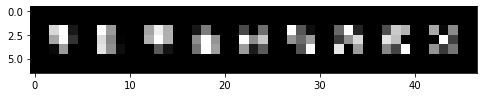

ff
[0.41057845 0.63198588 0.76016177 0.85931494 0.91608652 0.95518993
 0.97236761 0.98899805 1.        ]


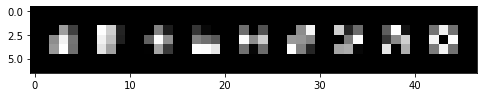

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1382/actrelu/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.20014955 0.36308479 0.46507306 0.55218637 0.62151406 0.67658654
 0.72165962 0.76135779 0.79206652 0.81866093 0.84384153 0.8629213
 0.87693533 0.89001903 0.90182389 0.91297522 0.92273963 0.93209639
 0.93942823 0.94659699]


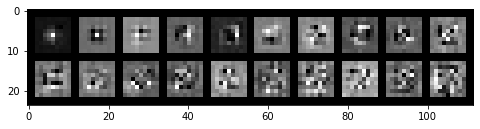

ff
[0.17649662 0.2920184  0.38585131 0.45372379 0.51650017 0.5712917
 0.61308597 0.64514355 0.67433278 0.70292988 0.72473539 0.74386378
 0.76220798 0.77902316 0.79515135 0.80908186 0.82268673 0.83457377
 0.84571309 0.85635495]


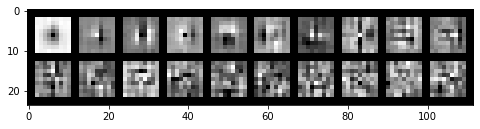

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6217184763692263
lateral
[0.27589829 0.46149982 0.63252659 0.77780946 0.86159941 0.93475923
 0.96541378 0.98834541 1.        ]


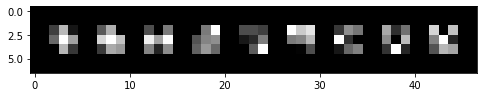

ff
[0.48002373 0.62654573 0.7598482  0.89273761 0.94401644 0.97391822
 0.98655057 0.99675668 1.        ]


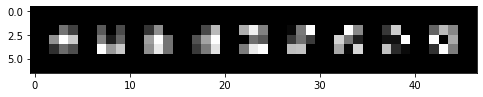

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1382/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.2836455  0.41142755 0.52198158 0.62095814 0.6856816  0.744968
 0.79398532 0.83337467 0.86223302 0.88375772 0.9012134  0.91391608
 0.92578996 0.93549901 0.94358799 0.95112624 0.95724975 0.96311287
 0.96768493 0.97182131]


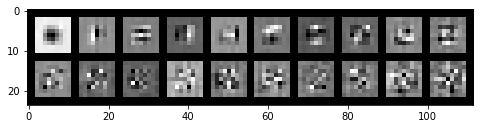

ff
[0.21277997 0.33912385 0.43125162 0.49790968 0.55129937 0.59942149
 0.64321814 0.67716531 0.70415134 0.72810868 0.74918978 0.76933567
 0.78790503 0.80246834 0.8167156  0.83025449 0.84250398 0.8539108
 0.86447004 0.87453666]


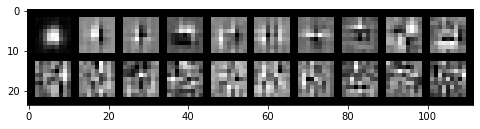

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6217184763692263
lateral
[0.27589829 0.46149982 0.63252659 0.77780946 0.86159941 0.93475923
 0.96541378 0.98834541 1.        ]


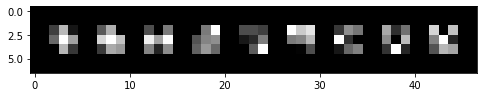

ff
[0.48002373 0.62654573 0.7598482  0.89273761 0.94401644 0.97391822
 0.98655057 0.99675668 1.        ]


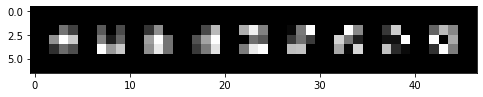

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1383/actrelu/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.24112647 0.39260149 0.49734475 0.5807672  0.63479141 0.67757108
 0.71912599 0.75711579 0.78808435 0.81250994 0.83512627 0.85443551
 0.87275422 0.88549539 0.89737678 0.90762589 0.91645727 0.9244522
 0.93228034 0.93906005]


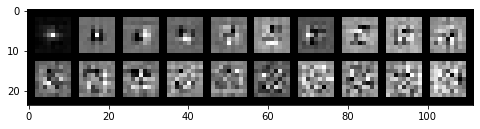

ff
[0.18540008 0.29600717 0.37523324 0.4459143  0.501558   0.55126351
 0.59368077 0.62821964 0.65670076 0.68459911 0.70849486 0.72990547
 0.75044512 0.76965938 0.78850068 0.80335737 0.81803247 0.83085143
 0.84113386 0.85134045]


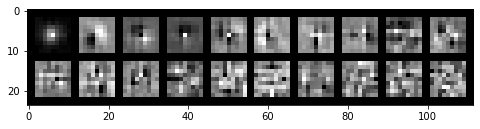

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6057464221765619
lateral
[0.27148395 0.4894733  0.61485605 0.73543086 0.81807099 0.89932328
 0.94314682 0.98544219 1.        ]


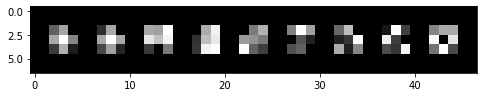

ff
[0.60903953 0.74897204 0.84866441 0.90042272 0.93921902 0.97401181
 0.987798   0.99552607 1.        ]


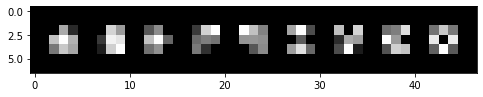

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1383/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.33492995 0.46992727 0.59289682 0.69619872 0.74882872 0.796789
 0.83689898 0.86886043 0.8912257  0.90952412 0.92406729 0.93478741
 0.94387487 0.9509069  0.95712643 0.96235866 0.96667505 0.97062629
 0.97388663 0.97681386]


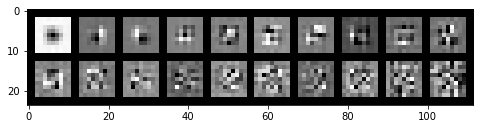

ff
[0.25718943 0.35898474 0.44420418 0.50860499 0.55530903 0.59709725
 0.6303533  0.66240617 0.69251181 0.71680211 0.73913667 0.76050497
 0.78067201 0.79781401 0.81463474 0.82992912 0.8433355  0.85564172
 0.86717004 0.87741539]


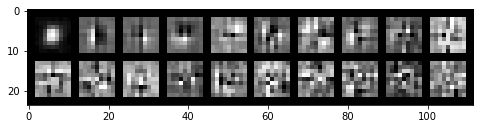

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6057464221765619
lateral
[0.27148395 0.4894733  0.61485605 0.73543086 0.81807099 0.89932328
 0.94314682 0.98544219 1.        ]


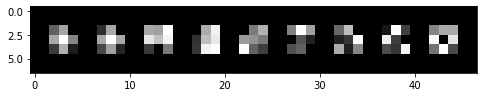

ff
[0.60903953 0.74897204 0.84866441 0.90042272 0.93921902 0.97401181
 0.987798   0.99552607 1.        ]


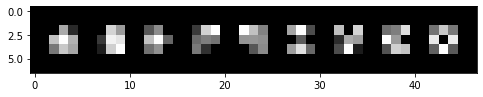

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1446/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.24593883 0.37539615 0.48022456 0.54684932 0.60299679 0.65433964
 0.69096128 0.72529387 0.75609101 0.78354471 0.80101231 0.81531804
 0.82890004 0.84183264 0.85395679 0.86563944 0.87586176 0.88470034
 0.89218171 0.89936414]


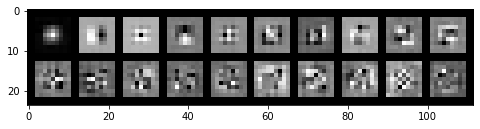

ff
[0.19953356 0.30827453 0.38873463 0.44930155 0.49793223 0.53701285
 0.57067374 0.60401106 0.63097766 0.6572487  0.67793848 0.69550686
 0.71203572 0.72852361 0.74323639 0.75681267 0.76919662 0.78111334
 0.79212121 0.80251171]


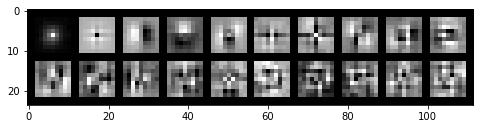

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6560397679703807
lateral
[0.32481856 0.49462142 0.65286718 0.76045662 0.84807015 0.92316548
 0.95852351 0.98182652 1.        ]


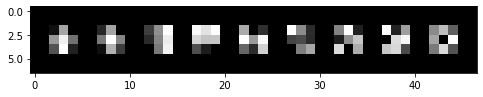

ff
[0.46470775 0.63022238 0.76922277 0.85513011 0.91118381 0.95808502
 0.97536003 0.99049847 1.        ]


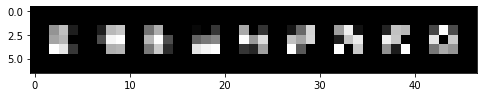

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1447/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.37736761 0.48942295 0.56432854 0.63257433 0.68972983 0.73769594
 0.77732658 0.80978373 0.83698722 0.85791558 0.87052054 0.8813512
 0.89137387 0.89972563 0.90711774 0.91401902 0.9203414  0.92641331
 0.93185682 0.93639139]


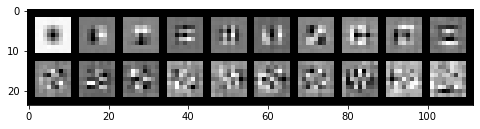

ff
[0.2520918  0.36126835 0.42094394 0.47736631 0.52502059 0.56838774
 0.60317179 0.63221669 0.65902579 0.68176255 0.70264892 0.7215032
 0.73896996 0.75425352 0.7684625  0.78189401 0.79437167 0.80662578
 0.81768741 0.82782248]


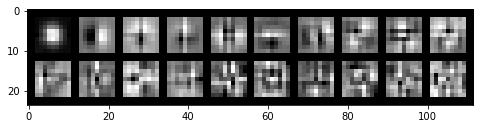

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6473001994061082
lateral
[0.34249359 0.51356436 0.65803928 0.75652165 0.84723518 0.92700517
 0.9560018  0.98036097 1.        ]


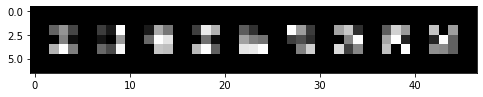

ff
[0.51370294 0.67001026 0.7802284  0.8639875  0.91872187 0.9604937
 0.97667247 0.99053642 1.        ]


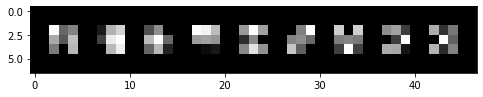

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1447/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
lateral
[0.28937943 0.39006532 0.48854512 0.5515013  0.6021946  0.64790269
 0.68521897 0.71786172 0.74755063 0.76953863 0.78866652 0.80266937
 0.81576781 0.82693727 0.83760956 0.84808874 0.85746122 0.86607665
 0.87412984 0.88160432]


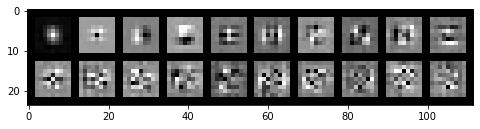

ff
[0.21503667 0.30679398 0.39275811 0.44995794 0.50063883 0.54042299
 0.57270755 0.60141608 0.62781801 0.65201219 0.67300858 0.69192344
 0.71025382 0.72632284 0.74088351 0.75409855 0.76630299 0.77788353
 0.7884318  0.79833377]


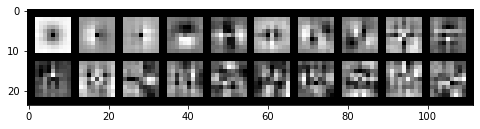

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6473001994061082
lateral
[0.34249359 0.51356436 0.65803928 0.75652165 0.84723518 0.92700517
 0.9560018  0.98036097 1.        ]


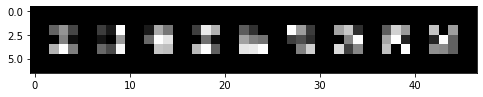

ff
[0.51370294 0.67001026 0.7802284  0.8639875  0.91872187 0.9604937
 0.97667247 0.99053642 1.        ]


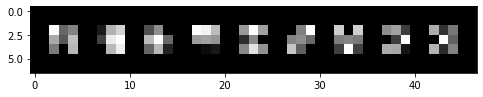

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1510/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.32453335 0.46432509 0.56133023 0.62144329 0.67499795 0.71613876
 0.75242464 0.78452883 0.81562863 0.84051368 0.85390977 0.86608338
 0.8765667  0.88499437 0.89257939 0.89951836 0.90614624 0.91188773
 0.91708262 0.92207571]


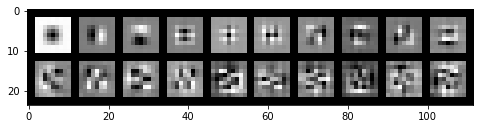

ff
[0.18322784 0.27505205 0.35410424 0.4161917  0.46416946 0.50635465
 0.54634749 0.57598791 0.60280784 0.62790324 0.65038908 0.67240587
 0.69344566 0.71371102 0.7293859  0.74314204 0.7568053  0.7691547
 0.78109623 0.79220153]


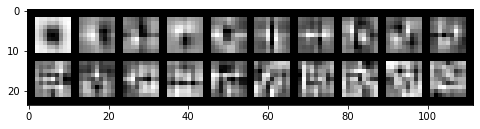

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6769850353199182
lateral
[0.33748459 0.51227298 0.6536486  0.78948713 0.86815814 0.94160595
 0.96389282 0.98416193 1.        ]


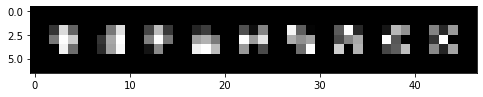

ff
[0.43502338 0.61541227 0.75006379 0.85245002 0.91021172 0.95361192
 0.97208512 0.98929042 1.        ]


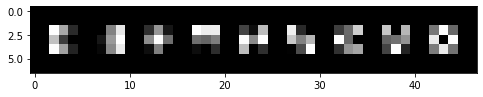

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1511/actrelu/lossmse/k9/bn_preTrue/model_seed0
lateral
[0.27491432 0.38176602 0.45584457 0.52678766 0.58273767 0.61831295
 0.64809248 0.67569935 0.699539   0.71900865 0.73676502 0.75079904
 0.76417894 0.77541998 0.78629388 0.79593878 0.80513469 0.81393676
 0.82221379 0.82970525]


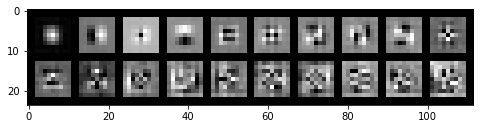

ff
[0.22963023 0.32871964 0.40262677 0.45539022 0.49916083 0.53155898
 0.5607247  0.58744115 0.61349884 0.63397071 0.65310591 0.67105674
 0.68789751 0.70238343 0.71534075 0.72799189 0.73916286 0.75006028
 0.75965619 0.76905085]


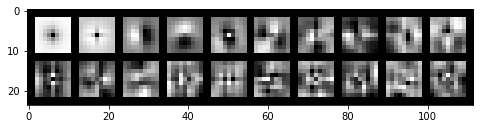

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6682068712511656
lateral
[0.4082035  0.58071475 0.70584182 0.81346374 0.88497724 0.94425662
 0.9647419  0.98297129 1.        ]


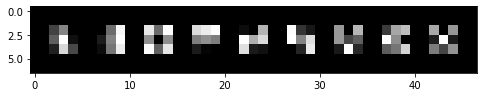

ff
[0.44488092 0.61826959 0.75117486 0.8517246  0.90810886 0.95146095
 0.96928503 0.9858945  1.        ]


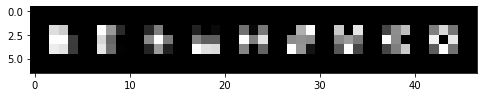

yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1511/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
lateral
[0.3875459  0.522425   0.61303512 0.67281761 0.72152566 0.75796954
 0.78663962 0.81393039 0.83469178 0.84950329 0.86028358 0.86989254
 0.87751058 0.88500168 0.89125987 0.89700863 0.90240101 0.90727045
 0.91199466 0.91644683]


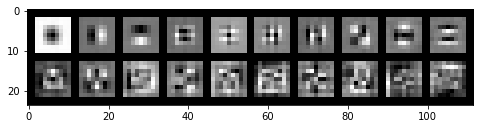

ff
[0.20476327 0.30551501 0.36859546 0.42934027 0.47479474 0.511611
 0.54442326 0.5754856  0.60197254 0.6269644  0.64896175 0.66868978
 0.68616183 0.70331605 0.71797929 0.73184962 0.74454594 0.75689387
 0.76783656 0.77832816]


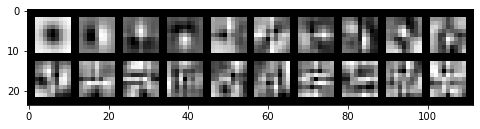

original model yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch32/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actsoftplus/r_c4/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se1, corr_norm^2 0.6682068712511656
lateral
[0.4082035  0.58071475 0.70584182 0.81346374 0.88497724 0.94425662
 0.9647419  0.98297129 1.        ]


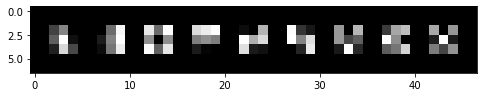

ff
[0.44488092 0.61826959 0.75117486 0.8517246  0.90810886 0.95146095
 0.96928503 0.9858945  1.        ]


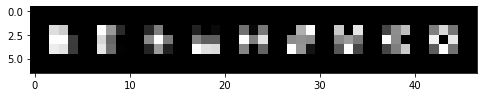

384


In [16]:
collect_all()